In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm #from tqdm.notebook  import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time as time_module
from mpl_toolkits import mplot3d

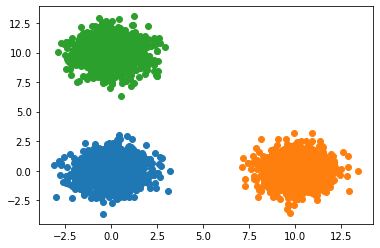

In [2]:
a = np.random.randn(1000, 2)
b = np.array([10, 0]) + np.random.randn(1000, 2)
c = np.array([0, 10]) + np.random.randn(1000, 2)

plt.figure()
plt.scatter(a[:, 0], a[:, 1])
plt.scatter(b[:, 0], b[:, 1])
plt.scatter(c[:, 0], c[:, 1])
plt.show()

# Implementation notes

VaDE versus CURL:


---


The differences are minor, you can easily show that the two are the same. Write this up at some point for reference.

VaDE objective function:
\begin{equation}
L_{VaDE} = \mathbb{E}_{q(\mathbf{z}\vert\mathbf{x})}\left[ \log p(\mathbf{x}\vert\mathbf{z}) \right] - \mathbb{E}_{q(\mathbf{y}\vert\mathbf{x})}\left[ KL(q(\mathbf{z}\vert\mathbf{x}))\Vert p(\mathbf{z}\vert \mathbf{y}))\right] - KL(q(\mathbf{y}\vert\mathbf{x})\Vert p(\mathbf{y}))
\end{equation}

CURL objective function:
\begin{equation}
L_{CURL} = \mathbb{E}_{q(\mathbf{z}\vert\mathbf{x}, \mathbf{y})q(\mathbf{y}\vert\mathbf{x})}\left[ \log p(\mathbf{x}\vert\mathbf{z}) \right] - \mathbb{E}_{q(\mathbf{y}\vert\mathbf{x})}\left[ KL(q(\mathbf{z}\vert\mathbf{x}, \mathbf{y}))\Vert p(\mathbf{z}\vert \mathbf{y}))\right] - KL(q(\mathbf{y}\vert\mathbf{x})\Vert p(\mathbf{y}))
\end{equation}

Important notes:
- Decoder: $p(\mathbf{x}\vert\mathbf{z}) \sim \mathcal{N}(\mathbf{x}\vert \mathbf{\mu}(\mathbf{z}), \mathbf{\sigma}^2(\mathbf{z})\mathbf{I})$
- Encoder: $q_{VaDE}(\mathbf{z}\vert \mathbf{x}) \sim \mathcal{N}(\mathbf{z}\vert \mathbf{\mu}_{\mathbf{z}}(\mathbf{x}), \mathbf{\sigma}_{\mathbf{z}}^2(\mathbf{x})\mathbf{I})$ OR $q_{CURL}(\mathbf{z}\vert \mathbf{x}, \mathbf{y}) \sim \mathcal{N}(\mathbf{z}\vert \mathbf{\mu}_{\mathbf{z}}(\mathbf{x}, \mathbf{y}), \mathbf{\sigma}_{\mathbf{z}}^2(\mathbf{x}, \mathbf{y})\mathbf{I})$
- Prior $p(\mathbf{z}\vert\mathbf{y}) \sim \mathcal{N}(\mathbf{z}\vert \mathbf{\mu}_{\mathbf{z}}(\mathbf{y}), \mathbf{\sigma}_{\mathbf{z}}^2(\mathbf{y})\mathbf{I}))$

- Prior $p(\mathbf{y}) \sim Cat(\mathbf{\pi})$ = $\prod_{k=1}^{K}\pi_k^{z_k}$

The final component is to define $q(\mathbf{y}\vert\mathbf{x})$. VaDE and CURL take vastly different approaches:

for VaDE:
$q(\mathbf{y}\vert\mathbf{x}) = p(\mathbf{y}\vert\mathbf{z}) = \frac{p(\mathbf{y})p(\mathbf{z}\vert\mathbf{y})}{\sum_{i=1}^Kp(\mathbf{y})p(\mathbf{z}\vert\mathbf{y})},$

where this equation also features in linear mixture models. This term is the posterior probability for y given an observation.

For CURL:
$q(\mathbf{y}\vert\mathbf{x})$ is part of the encoder, with a softmax 'task inference' head. I like this formulation a little less as I am not convinced that it works well.

Why do I say this? Well I noted one potentially problematic area in how CURL estimates the 'categorical regulariser'. From their code, they take a batch and take the average of the argmax of the labels $\mathbf{y}$, essentially estimating the batch class likelihood. The problem here is that it is not given that a batch will have equal samples from each 'hidden class', so I am not sure how useful this will be when there are unequal spread in the classes. Maybe you need to perform some pre-training inference for the prior $p(\mathbf{y})$.

It is natural, for the continuous distribution $q(\mathbf{z}\vert\cdots)$, to take a Monte Carlo estimate. However, the addition of the distribution categorial distribution, any expectation over $q(\mathbf{y}\vert\mathbf{x})$ then becomes a summation over K indices of the term in the expectation weighted by $q(\mathbf{y}=i\vert\mathbf{x})$.

Furthermore, for the middle KL divergence term, both distributions in the KL divergence are Gaussian and thus the KL divergence becomes:
$KL(\mathcal{N}_0\Vert\mathcal{N}_1) = \frac{1}{2}\left( tr(\Sigma_1^{-1}\Sigma_0) + (\mathbf{\mu}_1 - \mathbf{\mu}_0)^T\Sigma_1^{-1}(\mathbf{\mu}_1 - \mathbf{\mu}_0) - k + \log\left(\frac{det\Sigma_1}{det\Sigma_2}\right) \right)$,

where $\mathcal{N}_0\sim\mathcal{N}(\mathbf{\mu}_0, \Sigma_0)$, $\mathcal{N}_1\sim\mathcal{N}(\mathbf{\mu}_1, \Sigma_1)$ and $k$ is the dimensionality of the space covered by the distribution. If $\Sigma_1$ and $\Sigma_2$ are parametrised as diagonal covariance distributions $\Sigma_0 = \mathbf{\sigma_0^2}\mathbf{I}$ and $\Sigma_1 = \mathbf{\sigma_1^2}\mathbf{I}$ then

$KL(\mathcal{N}_0\Vert\mathcal{N}_1) = \frac{1}{2}\left( \sum_{i} \frac{\sigma^2_{0,i}}{\sigma^2_{1,i}} + \sum_i\left(\frac{\mu_{1,i} - \mu_{0,i})^2}{\sigma^2_{1,i}}\right)  - k + \sum_i \log\left(\frac{\sigma^2_{1, i}}{\sigma^2_{0, i}}\right)  \right)$,
$KL(\mathcal{N}_0\Vert\mathcal{N}_1) = \frac{1}{2}\sum_{i}\left(  \frac{\sigma^2_{0,i}}{\sigma^2_{1,i}} + \left(\frac{\mu_{1,i} - \mu_{0,i})^2}{\sigma^2_{1,i}}\right)  - 1 +  \log\left(\frac{\sigma^2_{1, i}}{\sigma^2_{0, i}}\right)  \right)$,

Finally, the final KL divergence term can be expanded as follows:
$=\sum_{k=1}^K q(\mathbf{y}=k\vert\mathbf{x}) \log \left( \frac{q(\mathbf{y}=k\vert\mathbf{x})}{p(\mathbf{y}=k)} \right)$


Let's now focus on the final KL term $KL(q(\mathbf{y}\vert\mathbf{x})\Vert p(\mathbf{y}))$. Since we know that this regularises the posterior conditional probability (i.e. the conditional probability given a sample from $\mathbf{x}$, which is actually a $\mathbf{z}$ if you think about where the MoG lies), we need a method to evaluate the KL term. The expansion of the term is straightforward:

$KL(q(\mathbf{y}\vert\mathbf{x})\Vert p(\mathbf{y})) = \mathbb{E}_{q(\mathbf{y}\vert\mathbf{x})}[\left( \log \frac{q(\mathbf{y}\vert\mathbf{x})}{p(\mathbf{y})} \right)]$

and since y is discrete:

$KL(q(\mathbf{y}\vert\mathbf{x})\Vert p(\mathbf{y})) = \sum_{k=1}^{K}q(\mathbf{y}=k\vert\mathbf{x})\left( \log \frac{q(\mathbf{y}=k\vert\mathbf{x})}{p(\mathbf{y}=k)} \right) = \sum_{k=1}^{K}q(\mathbf{y}=k\vert\mathbf{x})\left( \log \frac{q(\mathbf{y}=k\vert\mathbf{x})}{\pi_k} \right)$.

So, what do CURL and VaDE do? VaDE tries to estimate $p(\mathbf{y}=k\vert\mathbf{x})$ for each $\mathbf{x}$ while CURL uses a batch-estimated posterior and effectively directly parametrises $q(\mathbf{y}\vert\mathbf{x}) = \prod_{k=1}^{K} \gamma_{k}^{y_k}$, where $\gamma_{k}$ is the batch estimated class likelihood. 

I just realised there is an alternative derivation, unlike VaDE or CURL, one which allows one to use a cross-entropy term. Let's dissect the KL term even more: since we know $\pi_k$ is a constant scalar, we can separate the terms nicely:

$ KL(q(\mathbf{y}\vert\mathbf{x})\Vert p(\mathbf{y})) = \sum_{k=1}^{K}q(\mathbf{y}=k\vert\mathbf{x})\left( \log q(\mathbf{y}=k\vert\mathbf{x}) \right) -  \sum_{k=1}^{K}q(\mathbf{y}=k\vert\mathbf{x})\log \left( \pi_k \right) $

where the term on the right can be grouped with the $q(\mathbf{y}\vert\mathbf{x})$ terms in the previous objective functions. This leaves us with $\sum_{k=1}^{K}q(\mathbf{y}=k\vert\mathbf{x})\left( \log q(\mathbf{y}=k\vert\mathbf{x}) \right)$. What do we do with this? Well if we think about it a little, this is simply the negative of the entropy $\mathcal{H}(q(\mathbf{y}\vert\mathbf{x}))$, which can be considered as a cross-entropy loss. However, the difference is that we do not have labels and the labels, although they should be 1-of-K, will not be. Thus, it is better to leave it as the entropy. I believe Tensorflows softmax_cross_entropy_with_logits is better suited.

At the end of the day, I think simply taking the loss at face value is the way to proceed, monitoring $\mathcal{H}(q(\mathbf{y}\vert\mathbf{x}))$ will be useful as this will tell us if any information is encoded into $\mathbf{y}$, or if it is just left as is by the model. We want to minimize $\mathcal{H}(q(\mathbf{y}\vert\mathbf{x}))$, which the objective function does do for us when we maximise the ELBO (if you follow the signs for - $KL(q(\mathbf{y}\vert\mathbf{x})\Vert p(\mathbf{y}))$), which is a positive.

I found the following [entropy](https://adventuresinmachinelearning.com/cross-entropy-kl-divergence/) guide, [tensorflow](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits) implementation, [pytorch](https://discuss.pytorch.org/t/equivalent-of-tensorflows-sigmoid-cross-entropy-with-logits-in-pytorch/1985) vs [tensorflow](https://stackoverflow.com/questions/34240703/what-are-logits-what-is-the-difference-between-softmax-and-softmax-cross-entrop/39499486#39499486) discussion and [cross-entropy](https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html) discussion useful.

To make something clear: The loss we want to end up _minimising_ is $ KL(q(\mathbf{y}\vert\mathbf{x})\Vert p(\mathbf{y}))$ (as the ELBO is maximum when this term is zero [i.e. it detracts from the ELBO]) is the entropy $\mathcal{H}(\mathbf{y}\vert\mathbf{x})) -  \sum_{k=1}^{K}q(\mathbf{y}=k\vert\mathbf{x})\log \left( \pi_k \right) $


The alternative derivation was inspired by the semi-supervised paper by Kingma: Kingma DP, Rezende DJ, Mohamed S, Welling M (2014) Semi-supervised learning with deep generative models. Adv Neural Inf Process Syst 4:3581–3589

Another thing I just realised is, what if your latent space is large? You may end up with overflow or underflow errors when calculating $q(\mathbf{y}\vert\mathbf{x})$ for the VaDE case. How do we overcome this?

Assuming we have access to $\log p(\mathbf{z}\vert\mathbf{y})$ (which is a Gaussian, so of course we do), we can use the log-sum-exponential trick to calculate the denominator term. However, this will leave a log in the front of $q(\mathbf{y}\vert\mathbf{x})$ (as we design it to be $\log q(\mathbf{y}=k\vert\mathbf{x}) = \frac{\log (\pi_k p(\mathbf{z}\vert\mathbf{y} = k)}{\log \left(\sum_{k=1}^{K}\pi_k p(\mathbf{z}\vert\mathbf{y} = k) \right)}$ and apply log-sum-exp to the denominator). Then, it is as simple to subtract the LSE from the individually weighted logarithms ($\log (\pi_k p(\mathbf{z}\vert\mathbf{y} = k)$) and take the exponential of this function.

In summary: $\text{exp}(\log (\pi_k p(\mathbf{z}\vert\mathbf{y} = k)) - LSE(denominator)) = \text{exp}(\log (\pi_k) + \log( p(\mathbf{z}\vert\mathbf{y} = k)) - LSE(denominator))$. You will have to validate the numerical stability of this though... Check this [source](https://angusturner.github.io/generative_models/2017/11/03/pytorch-gaussian-mixture-model.html) which also does this and this [source](https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/) which discusses it more directly.

Some more things to think about (this is getting messy, I know): VaDE only needs expansion for the KL divergence between the categorical distribution, and you can use Gumbel-Softmax to stop the requirement for the loss to be sampled $K$ times! It effectively omits the $\mathbb{E}_{q(\mathbf{y}\vert\mathbf{x})}$ step. 

How does it work? It simply replaces the expectation over a discrete distribution with a continuous equivalent, which then allows us  to perform a Monte Carlo estimate, which just reduces to taking one sample. Very useful for the CURL method!






In [3]:
def apply_MLP_to_source(source,
                        num_layer,
                        num_segment = None,
                        iter4condthresh = 10000,
                        cond_thresh_ratio = 0.25,
                        layer_name_base = 'ip',
                        save_layer_data = False,
                        Arange=None,
                        nonlinear_type = 'ReLU',
                        negative_slope = 0.2,
                        random_seed=0):
    """Generate MLP and Apply it to source signal.
    Args:
        source: source signals. 2D ndarray [num_comp, num_data]
        num_layer: number of layers
        num_segment: (option) number of segments (only used to modulate random_seed)
        iter4condthresh: (option) number of random iteration to decide the threshold of condition number of mixing matrices
        cond_thresh_ratio: (option) percentile of condition number to decide its threshold
        layer_name_base: (option) layer name
        save_layer_data: (option) if true, save activities of all layers
        Arange: (option) range of value of mixing matrices
        nonlinear_type: (option) type of nonlinearity
        negative_slope: (option) parameter of leaky-ReLU
        random_seed: (option) random seed
    Returns:
        mixedsig: sensor signals. 2D ndarray [num_comp, num_data]
        mixlayer: parameters of mixing layers
    """
    if Arange is None:
        Arange = [-1, 1]
    #print("Generating sensor signal...")

    # Subfuction to normalize mixing matrix
    def l2normalize(Amat, axis=0):
        # axis: 0=column-normalization, 1=row-normalization
        l2norm = np.sqrt(np.sum(Amat*Amat,axis))
        Amat = Amat / l2norm
        return Amat

    # Initialize random generator
    np.random.seed(random_seed)

    # To change random_seed based on num_layer and num_segment
    for i in range(num_layer):
        np.random.rand()

    if num_segment is not None:
        for i in range(num_segment):
            np.random.rand()

    num_comp = source.shape[0]

    # Determine condThresh ------------------------------------
    condList = np.zeros([iter4condthresh])
    
    for i in range(iter4condthresh):
        A = np.random.uniform(Arange[0],Arange[1],[num_comp,num_comp])
        A = l2normalize(A, axis=0)
        condList[i] = np.linalg.cond(A)

    condList.sort() # Ascending order
    condThresh = condList[int(iter4condthresh * cond_thresh_ratio)]
    #print("    cond thresh: {0:f}".format(condThresh))

    # Generate mixed signal -----------------------------------
    mixedsig = source.copy()
    mixlayer = []
    for ln in range(num_layer-1,-1,-1):

        # Apply nonlinearity ----------------------------------
        if ln < num_layer-1: # No nolinearity for the first layer (source signal)
            if nonlinear_type == "ReLU": # Leaky-ReLU
                mixedsig[mixedsig<0] = negative_slope * mixedsig[mixedsig<0]
            else:
                raise ValueError

        # Generate mixing matrix ------------------------------
        condA = condThresh + 1
        while condA > condThresh:
            A = np.random.uniform(Arange[0], Arange[1], [num_comp, num_comp])
            A = l2normalize(A)  # Normalize (column)
            condA = np.linalg.cond(A)
            #print("    L{0:d}: cond={1:f}".format(ln, condA))
        # Bias
        b = np.zeros([num_comp]).reshape([1,-1]).T

        # Apply bias and mixing matrix ------------------------
        mixedsig = mixedsig + b
        mixedsig = np.dot(A, mixedsig)

        # Storege ---------------------------------------------
        layername = layer_name_base + str(ln+1)
        mixlayer.append({"name":layername, "A":A.copy(), "b":b.copy()})
        # Storege data
        if save_layer_data:
            mixlayer[-1]["x"] = mixedsig.copy()

    return mixedsig, mixlayer

In [4]:
# Datasets
class iVAE_datasets(object):
    
    def __init__(self, n, M, Lsegments, k, batch_size = 64, randomise = True, random_seed = False, mod_flag = False, mix_L = 1, Gauss_source = True, seed = True):
        """
        n = size of latent space
        M = no. classes
        Lsegments = no. samples per class
        k = no. of prior parameters
            k = 1: variance Gaussian
            k = 2: mean and variance gaussian
        mod_flag = case where one signal has mean modulation and the other doesn't
        """
        self.latent_size = n
        self.no_classes = M
        self.no_samples = Lsegments
        self.k = k
        self.batch_size = batch_size #specifies the batch size
        self.randomise = randomise #Specifies that sample must be obtained randomly (not uniformly)
        self.random_seed = random_seed #If random_seed = True - specifies that a random sample is required and the counter is not increased!
        self.mod_flag = mod_flag
        self.mix_L = mix_L
        self.Gauss_source = Gauss_source

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        #Define mixing model (Unused)
        #self.mixing_model = mixing_MLP(self.latent_size, 1)
        #self.mixing_model.to(self.device)
        #print(self.mixing_model)
        
        if self.k == 1 and not self.mod_flag:
            #print("\nVariance modulated sources.\n")
            self.mu_centers = np.zeros((self.no_classes, self.latent_size))
            
        elif self.k == 2 and not self.mod_flag:
            #print("\nMean and variance modulated sources.\n")
            if seed:
                np.random.seed(2**13 + 4)

            self.mu_centers = np.random.rand(self.no_classes, self.latent_size) * 10 - 5         # in range (-5, 5)
            self.mu_centers += np.sign(self.mu_centers) * 5 #Shift centers a outwards a little
       
        else:
            self.mu_centers = np.zeros((self.no_classes, self.latent_size))
            
            list_range = np.arange(0, self.no_classes, 1)
            np.random.shuffle(list_range) #random permutation gamma(u)
            
            a = np.random.random() * 10 - 5
            
            self.mu_centers[:, 1] =  a * list_range
            
        if not hasattr(self, "std_centers"):
            self.std_centers = np.random.rand(self.no_classes, self.latent_size) * 2.5 + 0.5      # in range (0.5, 3)
        
        #Make the sample labels
        self.sample_labels = []
        for i in range(self.no_classes):
            self.sample_labels += [i] * self.no_samples
        self.sample_labels = np.array(self.sample_labels)

        self.data = torch.from_numpy(self.sample()).to(self.device)
        
        #Normalise      
        self.data_mean = torch.mean(self.data, dim = 0)
        self.data_std = torch.std(self.data, dim = 0)
        
        self.data = (self.data - self.data_mean) / self.data_std

        mixed_data, mix_layer = apply_MLP_to_source(self.data.cpu().numpy().T, self.mix_L, num_segment = self.no_classes)
        mixed_data = torch.from_numpy(mixed_data.T).float()

        self.mix_layer = mix_layer 

        if self.mod_flag:
            self.mixed_data = torch.hstack((mixed_data[:, [0]], self.data[:, [1]]))
        
        else:
            self.mixed_data = mixed_data
        
        #Add noise
        self.mixed_data += torch.randn_like(self.mixed_data) * 0.01
        
        self.data_tuples = list(zip(self.data, self.sample_labels)) #list of tuples
        self.mixed_data_tuples = list(zip(self.mixed_data, self.sample_labels)) #list of tuples

        #shuffle mixed_data
        self.shuffled_data_index = np.arange(0, self.mixed_data.size(0), 1, dtype = int)

        if self.random_seed:
            np.random.shuffle(self.shuffled_data_index)

        #Convert self.sample_labels to torch.tensor
        self.sample_labels = torch.from_numpy(self.sample_labels)
    
    def sample(self):
        selected_centers = self.sample_labels
        
        latent_sample = self.mu_centers[selected_centers, :]

        if self.Gauss_source:
            latent_sample += np.random.randn(len(selected_centers), self.latent_size) * self.std_centers[selected_centers, :]
        elif not self.Gauss_source and self.latent_size == 2:
            s1 = np.random.laplace(loc = 0, scale = self.std_centers[selected_centers, 0]).reshape(-1, 1)
            s2 = np.random.laplace(loc = 0, scale = self.std_centers[selected_centers, 1]).reshape(-1, 1)
            latent_sample += np.hstack((s1, s2))
        return latent_sample.astype(np.float32)
    
    #turn the class into an iterator
    def __iter__(self):
        
        self.iter_cnt = 0 #initialises the iterator
        return self #returns the iterator object
    
    def __next__(self):

        if not self.random_seed:
            start = self.iter_cnt * self.batch_size
            end = start + self.batch_size

            index = self.shuffled_data_index[start:end]

            if end <= len(self.mixed_data_tuples):

                self.iter_cnt += 1
                
                data = self.mixed_data[index, :]
                labels = self.sample_labels[index]
                
                return data, labels

            else:
                self.iter_cnt= 0
                raise StopIteration

        else:
            print("Random sampler is not implemented.")
            raise SystemExit

# Objective functions

In [5]:
class GaussianLoss(nn.Module):
    def __init__(self, reduction = "sum"):
        super(GaussianLoss, self).__init__()
        self.reduction = reduction
    
    def forward(self, x_recon, x):

        if isinstance(x_recon, tuple):
            #Learnt a variance on the output
            mu_recon, var_recon = x_recon

        else:
            #No learnt variance on the output
            mu_recon = x_recon
            var_recon = torch.ones_like(x_recon).requires_grad_(False)
        
        error = x - mu_recon

        B, N = x.size()
        #Assuming diagonalised covariance:
        gauss_log_loss = torch.mul(error.pow(2), 1/(2 * var_recon + 1e-12)) #2x100 error vector is needed to do normal multiplication
        gauss_log_loss += 1/2 * torch.log(var_recon + 1e-12)

        #Sum over dimensionality
        gauss_log_loss = torch.sum(gauss_log_loss, dim = 1, keepdim = True)
        
        if self.reduction.lower() == "sum":
            gauss_log_loss =  torch.sum(gauss_log_loss)

        return gauss_log_loss #Unnormalised



class KL_divergence(nn.Module):

    """
    Implement the KL divergence loss for Gaussian distributions
    """

    def __init__(self, std_normal = False):
        super(KL_divergence, self).__init__()

        self.std_normal = std_normal #A flag to check whether the loss

    def forward(self, mu_0, var_0, mu_1 = None, var_1 = None):

        if self.std_normal:
            mu_1 = torch.zeros_like(mu_0).requires_grad_(False)
            var_1 = torch.ones_like(var_0).requires_grad_(False)

        #perform everything elementwise and then 
        Dkl = var_0 / var_1 + ((mu_1 - mu_0)**2) / var_1 - 1 + torch.log(var_1 / var_0  + 1e-12)

        #Sum over dimensionality
        Dkl = 0.5 * torch.sum(Dkl, dim = 1, keepdim = True)

        return Dkl #Unnormalised

class discrete_KL_divergence(nn.Module):
    """
    Implement the KL divergence loss for sampled distributions with likelihoods
    """
    def __init__(self, no_classes):
        super(discrete_KL_divergence, self).__init__()

        self.no_classes = no_classes

    def batch_wise_entropy(self, batch_likelihoods): #Maximise this term
        B = batch_likelihoods.size(0)

        p_hat = 1/B * torch.sum(batch_likelihoods, dim = 0).reshape(1, -1)

        #print(np.round(p_hat.detach().cpu().numpy(), 3))

        batch_entropy = -B * torch.sum(p_hat * torch.log(p_hat + 1e-12))
        #print(batch_entropy / B)
        return batch_entropy

    def forward(self, class_prob, prior_prob = None):

        assert class_prob.size(1) == self.no_classes, "There is a mis-match between the pre-defined number of classes and the number of classes given to the discrete KL divergence."

        if prior_prob is None:
              prior_prob = torch.ones(self.no_classes) / self.no_classes

        #perform everything elementwise and then you can reduce if required
        entropy = -1 * torch.sum(class_prob * torch.log(class_prob + 1e-12), dim = 1, keepdim = True) #Entropy term
        cross_entropy = -1 * torch.sum(class_prob * torch.log(prior_prob + 1e-12), dim = 1, keepdim = True)  #Cross-entropy term
        batch_entropy = self.batch_wise_entropy(class_prob) #Batch entropy term (maximise hence minus sign)
        Dkl = entropy - cross_entropy - batch_entropy

        return Dkl, torch.mean(entropy), torch.mean(cross_entropy) #Unnormalised and I sign-corrected the entropy term.

class MoG_VAE_loss(nn.Module):
    #No ability to learn a variance, variance is controlled by the noise distribution for iVAE
    def __init__(self, no_classes, loss_name = "L2", gamma = 1, beta = 1, alpha = 1, CURL_flag = False, Gumbel_flag = False):
        super(MoG_VAE_loss, self).__init__()

        self.no_classes = no_classes

        self.gamma = gamma #Reconstruction loss KL parameter
        self.beta = beta #Continuous KL parameter
        self.alpha = alpha #Categorial KL parameter

        self.loss_name = loss_name

        self.CURL_flag = CURL_flag
        self.Gumbel_flag = Gumbel_flag

        if self.loss_name.lower() == "l2":
            self.recon_loss = GaussianLoss(reduction = 'none')
        
        elif self.loss_name.lower() == "l1":
            self.recon_loss = nn.L1Loss(reduction = 'none')
        
        elif self.loss_name.lower() == "bce":
              self.recon_loss = nn.BCELoss(reduction = 'none')
        
        else:
            print("Unknown loss entered.")
            raise SystemExit
        
        self.kl_loss = KL_divergence(False) #Never use a standard VAE case
        self.discrete_kl_loss = discrete_KL_divergence(self.no_classes)
        
        #######################
        #Semi-supervised losses
        #######################
        if self.CURL_flag:
            self.ss_loss_classes = torch.nn.CrossEntropyLoss()
            self.ss_loss_posterior = torch.nn.NLLLoss()

        else:
            self.ss_loss_classes = torch.nn.NLLLoss()
            
        self.ss_loss_latent = nn.MSELoss()

    def forward(self, x, recon_x, mu_0, var_0, mu_1, var_1, q_y_G_x, prior_prob = None):
        
        #You need to expand the input data by no_classes and then reshape it!
        #x = torch.repeat_interleave(x, self.no_classes, dim = 0)

        B, N = x.size()

        if isinstance(recon_x, tuple) and self.loss_name.lower() != "l2": #Check if it is a tuple, will be this by default when it is fed in.
            recon_x = recon_x[0]

        #Reconstruction loss
        if self.CURL_flag: #second part of IF helps is you use Gumbel
            #Apply softmax to the output
            q_y_G_x = F.softmax(q_y_G_x, dim = 1)

            x = torch.repeat_interleave(x, self.no_classes, dim = 0)

            Lrecon = torch.sum(self.recon_loss(recon_x, x), dim = 1, keepdim = True)
            Lrecon = Lrecon.reshape(B, self.no_classes)
            Lrecon *= q_y_G_x #weight by categorical likelihood
            Lrecon = torch.sum(Lrecon) / self.no_classes  #Sum all values and normalise by no. of classes

        else:
            Lrecon = torch.sum(self.recon_loss(recon_x, x), dim = 1, keepdim = True)
            Lrecon = torch.sum(Lrecon)  #Sum all values

        if mu_0.size(0) * self.no_classes == mu_1.size(0): #A check to see if you are using single samples for many classes (VaDE only)
            mu_0 = torch.repeat_interleave(mu_0, self.no_classes, dim = 0) #Need to expand data for all the classes
            var_0 = torch.repeat_interleave(var_0, self.no_classes, dim = 0) #Need to expand data for all the classes

        #continuous KL divergence loss
        Lkl_continuous = self.kl_loss(mu_0, var_0, mu_1, var_1) #Need to normalise with same values reconstruction loss (Pytorch does this automatically unless you specify)
        
        if not self.Gumbel_flag:
            Lkl_continuous = Lkl_continuous.reshape(B, self.no_classes)
            Lkl_continuous *= q_y_G_x #weight by categorical likelihood
            
        Lkl_continuous = torch.sum(Lkl_continuous) / self.no_classes #Sum all values and normalise by class size

        #discrete KL divergence loss
        Lkl_discrete, entropy, cross_entropy = self.discrete_kl_loss(q_y_G_x, prior_prob)
        Lkl_discrete = torch.sum(Lkl_discrete)  #Sum all values

        Ltotal = self.gamma * Lrecon + self.beta * Lkl_continuous + self.alpha * Lkl_discrete

        #Normalise value
        Lrecon /= (B * N)
        Lkl_continuous /= (B * N)
        Lkl_discrete /= (B * N)
        Ltotal /= (B * N)

        return Ltotal, Lrecon, Lkl_continuous, Lkl_discrete, entropy, cross_entropy

"""
#TESTING THE FUNCTIONS
no_samples = 512
no_classes = 3
a = torch.randn(no_samples, 5)
b = a + torch.randn_like(a) * 0.1
mu_0 = torch.ones_like(a)
mu_1 = torch.zeros_like(a)
var_0 = torch.ones_like(a)
var_1 = torch.ones_like(a)

a = torch.repeat_interleave(a, no_classes, dim = 0)
b = torch.repeat_interleave(b, no_classes, dim = 0)
mu_0 = torch.repeat_interleave(mu_0, no_classes, dim = 0)
mu_1 = torch.repeat_interleave(mu_1, no_classes, dim = 0)
var_0 = torch.repeat_interleave(var_0, no_classes, dim = 0)
var_1 = torch.repeat_interleave(var_1, no_classes, dim = 0)

loss = MoG_VAE_loss(no_classes)
q_y_G_x = torch.ones(no_samples, no_classes) / no_classes

print(loss(a, b, mu_0, var_0, mu_1, var_1, q_y_G_x, False))
print(loss(a, b, mu_0, var_0, mu_1, var_1, q_y_G_x, True))
print(torch.mean((b - a)**2)/2, torch.mean((b - a)**2)/(2 * no_classes))
"""

'\n#TESTING THE FUNCTIONS\nno_samples = 512\nno_classes = 3\na = torch.randn(no_samples, 5)\nb = a + torch.randn_like(a) * 0.1\nmu_0 = torch.ones_like(a)\nmu_1 = torch.zeros_like(a)\nvar_0 = torch.ones_like(a)\nvar_1 = torch.ones_like(a)\n\na = torch.repeat_interleave(a, no_classes, dim = 0)\nb = torch.repeat_interleave(b, no_classes, dim = 0)\nmu_0 = torch.repeat_interleave(mu_0, no_classes, dim = 0)\nmu_1 = torch.repeat_interleave(mu_1, no_classes, dim = 0)\nvar_0 = torch.repeat_interleave(var_0, no_classes, dim = 0)\nvar_1 = torch.repeat_interleave(var_1, no_classes, dim = 0)\n\nloss = MoG_VAE_loss(no_classes)\nq_y_G_x = torch.ones(no_samples, no_classes) / no_classes\n\nprint(loss(a, b, mu_0, var_0, mu_1, var_1, q_y_G_x, False))\nprint(loss(a, b, mu_0, var_0, mu_1, var_1, q_y_G_x, True))\nprint(torch.mean((b - a)**2)/2, torch.mean((b - a)**2)/(2 * no_classes))\n'

# Networks

In [6]:
#Implement similarly to the manner I had previously
#Dict to define layers
#Checks for FF and Convolution
#Add in ability to have variance generating component in decoder (unused at this point)

class Unflatten(nn.Module):
    def __init__(self, ModelDict):
        super(Unflatten, self).__init__()
        self.ModelDict = ModelDict
        
    def forward(self, input_tensor):
        
        First_no_channels = self.ModelDict["channels"][0]

        input_tensor = input_tensor.view(-1, First_no_channels, int(input_tensor.size(1) / First_no_channels))
        
        return input_tensor

class Flatten(nn.Module): #Same name as tensorflow tf.keras.Flatten()just because it makes sense
    def __init__(self, DisDict):
        super(Flatten, self).__init__()
        self.DisDict = DisDict
        
    def forward(self, input_tensor):

        input_tensor = input_tensor.view(input_tensor.size(0), -1)
        
        return input_tensor

class Gumbel_sampler(nn.Module):
    def __init__(self, no_classes, train_epochs, temp_init = 10, temp_end = 0.1, decay_type = "linear"):
        super(Gumbel_sampler, self).__init__()
        self.no_classes = no_classes
        self.train_epochs = train_epochs
        self.temp_init = temp_init
        self.temp_end = temp_end
        self.current_temp = temp_init
        self.decay_type = decay_type.lower()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        assert self.temp_init >= self.temp_end, print("Gumbel sampler temperatures are not correct, you are growing the temperature with the epochs.")
        assert self.decay_type == "exponential" or self.decay_type == "linear", print("Unknown decay type entered.")

    def decay_temp(self, epoch):
        epoch_norm = epoch / self.train_epochs

        if self.decay_type == 'linear':
          self.current_temp = self.temp_init + (self.temp_end - self.temp_init) * epoch_norm
        
        elif self.decay_type == 'exponential':
          self.current_temp = self.temp_init * np.exp(np.log(self.temp_end / self.temp_init ) * epoch_norm)

    def sample_g(self, batch_size):
        u = torch.rand(batch_size, self.no_classes).to(self.device)
        g = -torch.log(-torch.log(u + 1e-12) + 1e-12)

        return g
    
    def forward(self, log_likelihoods, epoch_no = None):
        
        B = log_likelihoods.size(0)
        
        g_sample = self.sample_g(B)

        gumbel_sample = F.softmax(torch.exp( (log_likelihoods + g_sample) / self.current_temp ), dim = 1)

        return gumbel_sample
"""

a = Gumbel_sampler(5, 100)

fig, ax = plt.subplots(10, 10, figsize = (20, 20))
ax = ax.flatten()
logs = torch.log(torch.tensor([[0.2] * 5]))

print(logs)
for i in range(100):

    samples = a(logs, i + 1, anneal_flag = True)

    ax[i].bar(range(samples.size(1)), samples[0, :], align='center', alpha=0.5)

plt.show()
"""

#########################################################################  
class MoG_Encoder(nn.Module):
    def __init__(self, latent_size, no_classes, data_size, encode_dict, epochs, CURL_flag = False, Gumbel_flag = False):

        #The purpose of the CURL flag is to specify whether we learn a classification layer
        #or if we estimate the class from the data. 

        super(MoG_Encoder, self).__init__()

        self.latent_size = latent_size
        self.no_classes = no_classes #Controls the size of the class space
        self.data_size = data_size
        self.encode_dict = encode_dict
        self.CURL_flag = CURL_flag
        self.Gumbel_flag = Gumbel_flag
        self.activation = nn.LeakyReLU(0.1)
        self.var_activation = nn.Softplus()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        #Check if it is a standard VAE through no_classes
        if self.no_classes == 0:
            print("You are using a MoG VAE but have set the class size to zero... why?")
            raise SystemExit
        
        if self.CURL_flag:
            print("\nUsing CURL formulation, so the model has a class label head.")
        
        if self.Gumbel_flag:
            self.gumbel_sampler = Gumbel_sampler(self.no_classes, epochs)

        self.layers = [] #Initialise layers 

        if self.encode_dict["conv_flag"]:
            
            for i in range(len(self.encode_dict["channels"]) - 1):

                #append the layer
                self.layers.append( nn.Conv1d(in_channels = self.encode_dict["channels"][i], out_channels = self.encode_dict["channels"][i + 1], kernel_size = self.encode_dict["kernel_size"][i], stride = self.encode_dict["stride"][i], padding = self.encode_dict["padding"][i]) )
                #append the activation function
                self.layers.append(self.activation)
            
            #append the transform to take the nn.linear to a convolutional layer
            self.layers.append(Flatten(self.encode_dict))
      
        for i in range(len(self.encode_dict["ff_layers"]) - 2):
            #append the layer
            self.layers.append(nn.Linear(in_features = self.encode_dict["ff_layers"][i], out_features = self.encode_dict["ff_layers"][i + 1], bias = True))
            #append the activation function
            self.layers.append(self.activation)

        self.layers.pop(-1)
        self.encode_net = nn.Sequential(*self.layers) #hidden representation that gets fed into predicting the label and latent 

        if self.CURL_flag:

            #if not self.Gumbel_flag:
            #    self.y_layer = nn.Sequential(nn.Linear(self.encode_dict["ff_layers"][-2], self.no_classes), nn.Softmax(dim = 1))

            #else:
            self.y_layer = nn.Sequential(nn.Linear(self.encode_dict["ff_layers"][-2], self.no_classes)) #Only return the log-likelihoods. argmax should still be suitable

            #If it is CURL, you need to feed x and y to get z ~ q(z|x, y)
            self.mu_layer = nn.Linear(self.encode_dict["ff_layers"][-2] + self.no_classes, self.encode_dict["ff_layers"][-1])
            self.var_layer = nn.Sequential(nn.Linear(self.encode_dict["ff_layers"][-2] + self.no_classes, self.encode_dict["ff_layers"][-1]), self.var_activation)
        
        else:
            self.mu_layer = nn.Linear(self.encode_dict["ff_layers"][-2], self.encode_dict["ff_layers"][-1])
            self.var_layer = nn.Sequential(nn.Linear(self.encode_dict["ff_layers"][-2], self.encode_dict["ff_layers"][-1]), self.var_activation)
        
        #Initialise weights if you want to
        self.encode_net.apply(self.init_weights)
        self.mu_layer.apply(self.init_weights)
        self.var_layer.apply(self.init_weights)

        if self.CURL_flag:
            self.y_layer.apply(self.init_weights)
    
    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight)
            #m.bias.data.fill_(0.01)
  
    def forward(self, x, cont_input = None, expand_flag = True):
        
        #Always stack as [x, conditional labels]
        #expand_flag controls whether we expand x_input to account for K classes or if we just wish to feed the samples through the model.
        #If you don't use the expand flag and you use CURL, then feed y_x from classification head layer in.
        #We need to specify the class labels, however for VaDE these are estimated from p(y|x) not q(y|x)
            
        #Account for any conditioning variables
        if cont_input is not None:
            x_input = torch.hstack((x, cont_input))

        else:
            x_input = x
        
        encode = self.encode_net(x_input)
        
        if self.CURL_flag:
            y_x = self.y_layer(encode) #Model predicted class labels, done on non-expanded data as these are essentially weights for likelihood or KL terms

        else:#VaDE
            y_x = None #Do nothing

        with torch.no_grad(): #We still want the expanded class labels so still make them!
            labels = torch.arange(self.no_classes).repeat(x.size(0)).type(torch.long)# #Repeat labels for each sample, required when we use CURL to control the y's. 
            #Labels are always expanded!
            
            labels = labels.to(self.device)
            
            class_input = F.one_hot(labels, num_classes = self.no_classes).type(torch.float32)
            class_input = class_input.to(self.device)
        
        if expand_flag and self.CURL_flag and self.Gumbel_flag:
            #The expansion is only necessary for CURL, but Gumbel stops this!
            #For VaDE, you do not need to expand the samples! Only the KL divergence needs to be expanded
            #Expand the data
            if self.Gumbel_flag: #Only useful during training, when you 
                y_x = self.gumbel_sampler(y_x)

            #encode data
            encode = torch.hstack((encode, y_x))

        elif expand_flag and self.CURL_flag and not self.Gumbel_flag: 
            #The expansion is only necessary for CURL, but Gumbel should not stop this
            #For VaDE, you do not need to expand the samples!Only the KL divergence needs to be expanded
            #Expand the data
            x_input = torch.repeat_interleave(x_input, self.no_classes, dim = 0)
            encode = self.encode_net(x_input)
            
            #predict label
            y_pred = self.y_layer(encode)

            #encode data
            encode = torch.hstack((encode, y_pred))

        elif not expand_flag and y_x is not None: #If you don't perform training and you use CURL, feed q(y|x) head into encoder
            encode = torch.hstack((encode, F.softmax(y_x, dim = 1) )) #Need to compute softmax on the data to feed through network
        
        mu_z = self.mu_layer(encode)
        var_z = self.var_layer(encode)
            
        return mu_z, var_z, y_x, class_input
#########################################################################    

class MoG_Decoder(nn.Module):
    def __init__(self, latent_size, no_classes, data_size, decode_dict, var_flag = False, binary_flag = False):
        super(MoG_Decoder, self).__init__()

        self.latent_size = latent_size
        self.no_classes = no_classes
        self.data_size = data_size
        self.decode_dict = decode_dict
        self.var_flag = var_flag
        self.binary_flag = binary_flag
        self.activation = nn.LeakyReLU(0.1)    
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.layers = [] #Initialise layers 

        print("\nTake note, this decoder also returns the latent sample, as you need it for the VaDE estimation step (and if you want to do it analytically)")
        
        if not self.decode_dict["conv_flag"]:
            for i in range(len(self.decode_dict["ff_layers"]) - 2):
                #append the layer
                self.layers.append(nn.Linear(in_features = self.decode_dict["ff_layers"][i], out_features = self.decode_dict["ff_layers"][i + 1], bias = True))
                #append the activation function
                self.layers.append(self.activation)
            
            self.layers.pop(-1) #remove the final activation for linear outputs
    
            self.decode_net = nn.Sequential(*self.layers)
            self.gen_layer = nn.Linear(self.decode_dict["ff_layers"][-2], self.decode_dict["ff_layers"][-1])
            
            if self.binary_flag: #For MNIST or something like that
                print("Making binary layer")
                self.gen_layer = nn.Sequential(self.gen_layer, nn.Sigmoid())

            if self.var_flag:
                self.var_layer = nn.Sequential(nn.Linear(self.decode_dict["ff_layers"][-2], self.decode_dict["ff_layers"][-1]), nn.Softplus())
                #self.var_layer.apply(self.init_weights)
        
         
        else:
            for i in range(len(self.decode_dict["ff_layers"]) - 1):
                #append the layer
                self.layers.append(nn.Linear(in_features = self.decode_dict["ff_layers"][i], out_features = self.decode_dict["ff_layers"][i + 1], bias = True))
                #append the activation function
                self.layers.append(self.activation)
        
            #append the transform to take the nn.linear to a convolutional layer
            self.layers.append(Unflatten(self.decode_dict))
            
            for i in range(len(self.decode_dict["channels"]) - 2):

                #append the layer
                self.layers.append( nn.ConvTranspose1d(in_channels = self.decode_dict["channels"][i], out_channels = self.decode_dict["channels"][i + 1], kernel_size = self.decode_dict["kernel_size"][i], stride = self.decode_dict["stride"][i], padding = self.decode_dict["padding"][i]) )
                #append the activation function
                self.layers.append(self.activation)
        
            self.layers.pop(-1) #remove the final activation for linear outputs
    
            self.decode_net = nn.Sequential(*self.layers)
            self.gen_layer = nn.ConvTranspose1d(in_channels = self.decode_dict["channels"][-2], out_channels = self.decode_dict["channels"][-1], kernel_size = self.decode_dict["kernel_size"][-1], stride = self.decode_dict["stride"][-1], padding = self.decode_dict["padding"][-1])
            
            if self.binary_flag: #For MNIST or something like that
                print("Making binary layer")
                self.gen_layer = nn.Sequential(self.gen_layer, nn.Sigmoid())

            self.decode_net.apply(self.init_weights)
            self.gen_layer.apply(self.init_weights)

            if self.var_flag:
                self.var_layer = nn.Sequential(nn.ConvTranspose1d(in_channels = self.decode_dict["channels"][-2], out_channels = self.decode_dict["channels"][-1], kernel_size = self.decode_dict["kernel_size"][-1], stride = self.decode_dict["stride"][-1], padding = self.decode_dict["padding"][-1])
                                               , nn.Softplus())
                self.var_layer.apply(self.init_weights)
        

    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight)
            #m.bias.data.fill_(0.01)

    @staticmethod
    def reparametrisation_trick(mu_data, var_data):
        with torch.no_grad():
            eta = torch.randn_like(mu_data)

        return mu_data + eta * torch.sqrt(var_data)

    def forward(self, mu_latent, var_latent):

        z_latent = self.reparametrisation_trick(mu_latent, var_latent)

        decode_out = self.decode_net(z_latent)

        x_out = self.gen_layer(decode_out)

        if self.var_flag:
            var_out = self.var_layer(decode_out)
            
        else:
            var_out = torch.ones_like(x_out).requires_grad_(False)
        
        if self.decode_dict["conv_flag"]:
            x_out = x_out.squeeze(1)
            var_out = var_out.squeeze(1)
            
        return x_out, var_out, z_latent

class MoG_ConditionalPrior(nn.Module):
    #Can adapt to have parametric densities... (only a mean and variance parameter depending on the class)
    #I think for the MoG case, you can use continuous_prior = False (unless you use Gumbel softmax, then you realistically cannot)
    #Assumption for labels fed in: They are one-hot encoded! (Remember this)

    def __init__(self, latent_size, no_classes, data_size, prior_dict, continuous_prior = False):
        super(MoG_ConditionalPrior, self).__init__()

        self.latent_size = latent_size
        self.no_classes = no_classes
        self.data_size = data_size
        self.prior_dict = prior_dict
        self.continuous_prior = continuous_prior

        self.activation = nn.LeakyReLU(0.1)
        self.var_activation = nn.Softplus()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        #Check if it is a standard VAE, if so, set continuous_prior to False and then set distribution to N(0, I)
        if self.no_classes == 0:
            print("You are using a MoG VAE but have set the class size to zero... why?")
            raise SystemExit

        self.layers = [] #Initialise layers 
        
        if self.continuous_prior:
            #Define model - essentially another generator but with only FF layers, by design

            for i in range(len(self.prior_dict["ff_layers"]) - 2):
                #append the layer
                self.layers.append(nn.Linear(in_features = self.prior_dict["ff_layers"][i], out_features = self.prior_dict["ff_layers"][i + 1], bias = True))
                #append the activation function
                self.layers.append(self.activation)
          
            self.layers.pop(-1)
            self.prior_net = nn.Sequential(*self.layers)
            self.prior_mu = nn.Linear(self.prior_dict["ff_layers"][-2], self.prior_dict["ff_layers"][-1])
            self.prior_var = nn.Linear(self.prior_dict["ff_layers"][-2], self.prior_dict["ff_layers"][-1])

            #self.prior_net.apply(self.init_weights)
            #self.prior_mu.apply(self.init_weights)
            #self.prior_var.apply(self.init_weights)
      
        else: #Label gives a mean and variance.
            #Lambda functions that just return the mean and variance parameters at all the class locations of interest!
            self.prior_net = lambda U: U #Just a way to bypass the prior_net step in the forward method()

            if self.no_classes == 0: #Standard VAE implementation, not useful here
                #self._prior_mu_ = nn.parameter.Parameter(torch.Tensor(1, self.latent_size))
                #self._prior_var_ = nn.parameter.Parameter(torch.Tensor(1, self.latent_size))
                self.register_parameter(name='_prior_mu_', param=torch.nn.Parameter(torch.Tensor(1, self.latent_size), requires_grad = True))
                self.register_parameter(name='_prior_var_', param=torch.nn.Parameter(torch.Tensor(1, self.latent_size), requires_grad = True))

            else:
                self.register_parameter(name='_prior_mu_', param=torch.nn.Parameter(torch.Tensor(self.no_classes, self.latent_size), requires_grad = True))
                self.register_parameter(name='_prior_var_', param=torch.nn.Parameter(torch.Tensor(self.no_classes, self.latent_size), requires_grad = True))
                #self._prior_mu_ = nn.parameter.Parameter(torch.Tensor(self.no_classes, self.latent_size))
                #self._prior_var_ = nn.parameter.Parameter(torch.Tensor(self.no_classes, self.latent_size))#torch.ones(self.no_classes, self.latent_size).to(self.device)#

                self.prior_mu = lambda U: self._prior_mu_[torch.argmax(U, dim = 1), :]
                self.prior_var = lambda U: self._prior_var_[torch.argmax(U, dim = 1), :]

            with torch.no_grad(): #initialise parameters
                if self.no_classes == 0:
                    #Set to N(0, I)
                    self._prior_mu_.fill_(0)
                    self._prior_var_.fill_(1)
                    #Turn off gradient flag
                    self._prior_mu_.requires_grad_(False)
                    self._prior_var_.requires_grad_(False)
                    
                else:
                    self._prior_mu_.normal_(0, 1)
                    self._prior_var_.normal_(0, 1)

    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            #m.bias.data.fill_(0.01)
    
    def forward(self, labels = None, cont_input = None): #labels = None for the standard VAE case.
        #Always stack as [continuous, discrete]
        if self.no_classes == 0: #For a standard VAE, not useful here.
            return self._prior_mu_, self._prior_var_

        else:
            u_input = labels
            
            if cont_input is not None:
                u_input = torch.hstack((cont_input, u_input))

            prior_net = self.prior_net(u_input)
            mu = self.prior_mu(prior_net)
            var = self.var_activation(self.prior_var(prior_net)) 
            
            return mu, var

class MoG_ClassPrior(nn.Module):
    def __init__(self, latent_size, no_classes, data_size):
        super(MoG_ClassPrior, self).__init__()
        
        self.latent_size = latent_size
        self.no_classes = no_classes
        self.data_size =data_size

        self.register_parameter(name='prior_prob', param=torch.nn.Parameter(torch.Tensor(1, self.no_classes), requires_grad = False))
        self.prior_prob.fill_(1/self.no_classes)

        self.gauss_loss = GaussianLoss(reduction = 'none') #This already calculates the NLL, so you just need to add (D/2d*log(2pi)) and multiply the sum by -1

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    def posterior_likelihood(self, latent_samples, mu_class, var_class, log_flag = False):
        #Method:
        #-------
        # Calculates p(y|x) for the user. p(y|x) = p(y)p(z|y) / SUM(p(y)p(z|y)) - specifically for VaDE
        # Need to calculate log p(z|y) (prior likelihood)
        # p(y) is defined in this class through self.prior_prob
        # Need to perform log-sum-exp trick to calculate denominator without overflow
        #-------

        #For each x, push to latent space and resample using reparametrisation trick and calculate log-likelihood of z under p(z|y=k) (thus, you need no_class likelihood for 1 z sample)
        #Then calculate p(y=k|x) using 

        if latent_samples.size(0) * self.no_classes == mu_class.size(0): #A check to see if you are using single samples for many classes (VaDE only)
            latent_samples = torch.repeat_interleave(latent_samples, self.no_classes, dim = 0)

        kB, z_size = latent_samples.size()
        B = kB // self.no_classes

        log_samples = -1 * ( self.gauss_loss((mu_class, var_class), latent_samples) + self.latent_size/2 * (np.log(2 * np.pi)) )

        log_samples = log_samples.reshape(B, self.no_classes) + torch.log(self.prior_prob)

        logsumexp_denominator = torch.logsumexp(log_samples, dim = 1, keepdim = True)
        
        if log_flag:
            q_y_G_x = log_samples - logsumexp_denominator #log likelihoods
        
        else:
            q_y_G_x = torch.exp(log_samples - logsumexp_denominator) #Normal probabilities

        return q_y_G_x





# Model object

In [7]:
class MoG_VAE_model(nn.Module):
    def __init__(self, input_size, latent_size, no_classes = None, epochs = None, EncodeDict = None, DecodeDict = None, PriorDict = None, binary_decode = False, var_decode = False, continuous_prior = False, CURL_flag = True, Gumbel_flag = False):
        super(MoG_VAE_model, self).__init__()
        
        self.input_size = input_size
        self.latent_size = latent_size
        self.no_classes = no_classes
        self.encode_dict = EncodeDict
        self.decode_dict = DecodeDict
        self.prior_dict = PriorDict
        self.binary_decode = binary_decode
        self.var_decode = var_decode
        self.continuous_prior = continuous_prior
        self.CURL_flag = CURL_flag
        self.Gumbel_flag = Gumbel_flag

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.model_HI_names = ["HI_1"]
        self.model_HI_names_pretty = [r"$NLL_{recon}$"]

        self.encoder = MoG_Encoder(self.latent_size, self.no_classes, self.input_size, self.encode_dict, epochs, CURL_flag = self.CURL_flag, Gumbel_flag = self.Gumbel_flag)
        self.decoder = MoG_Decoder(self.latent_size, self.no_classes, self.input_size, self.decode_dict, var_flag = var_decode, binary_flag = self.binary_decode)
        self.prior = MoG_ConditionalPrior(self.latent_size, self.no_classes, self.input_size, self.prior_dict, continuous_prior = self.continuous_prior)
        self.class_prior = MoG_ClassPrior(self.latent_size, self.no_classes, self.input_size)

        if self.no_classes == 0:
            print("Why are you using a MoG VAE with no classes?")
            raise SystemExit

    def train(self):
        self.encoder.train()
        self.decoder.train()
        self.prior.train()
        self.class_prior.train()
    
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()
        self.prior.eval()
        self.class_prior.eval()

    def to(self, device):
        self.encoder.to(device)
        self.decoder.to(device)
        self.prior.to(device)
        self.class_prior.to(device)
    
    def one_hot_encode(self, labels):

        with torch.no_grad():
            label_mat = torch.zeros(labels.size(0), self.no_classes)
            label_mat[range(labels.size(0)), labels] = 1

            return label_mat

    def compute_HIs(self, x, labels = None, cont_input = None): #Only useful if you are performing anomaly detection (specific to another project)
        with torch.no_grad():

            mu_latent, var_latent, _, _ = self.encoder(x, expand_flag = False)

            x_recon1, var_decoder, _ =  self.decoder(mu_latent, var_latent) 
            HI_1 = (1 / x.shape[1]) * torch.sum((x - x_recon1)**2 / (var_decoder), dim = 1) 

            return HI_1, mu_latent
    
    def infer_label(self, x):

        with torch.no_grad():
            #Posterior labels
            mu_latent, var_latent, y_pred, class_labels = self.encoder(x, expand_flag = False) 

            z_latent = self.decoder.reparametrisation_trick(mu_latent, var_latent)

            mu_prior, var_prior = self.prior(class_labels)

            q_y_G_x = self.class_prior.posterior_likelihood(z_latent, mu_prior, var_prior)

            posterior_labels = torch.argmax(q_y_G_x, dim = 1)

            #CURL evaluation
            if self.encoder.CURL_flag:
                curl_labels = torch.argmax(y_pred, dim = 1)

            else:
                curl_labels = None

            return posterior_labels, curl_labels

class MoG_VAE_optimiser(object):
    def __init__(self, model, Params, CURL_flag, ss_flag):

        self.CURL_flag = CURL_flag
        self.ss_flag = ss_flag

        ls = list(model.encoder.parameters()) + list(model.decoder.parameters()) + list(model.prior.parameters()) + list(model.class_prior.parameters())
        self.MoG_VAE_opt = torch.optim.Adam(ls, lr = 1e-4)
        print("\n\ndefault LR is 1e-3.\n\n")

        ##################
        #Semi-supervised
        ##################

        if self.ss_flag:
          if self.CURL_flag:
              self.ss_opt_latent = torch.optim.Adam(model.encoder.parameters(), lr = 1e-3) #Classification
              self.ss_opt_posterior = torch.optim.Adam(list(model.encoder.parameters()) + list(model.prior.parameters()), lr = 1e-3) #Classification (on Bayesian posterior)
          
          else:
              self.ss_opt_latent = torch.optim.Adam(list(model.encoder.parameters()) + list(model.prior.parameters()), lr = 1e-3)
          
          self.ss_opt_data = torch.optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()), lr = 1e-3)#Latent and reconstruction (pair-wise loss)
      
    def step_unsupervised(self):
        self.MoG_VAE_opt.step()
    
    def step_supervised_latent(self):
        self.ss_opt_latent.step()
    
    def step_supervised_posterior(self):
        self.ss_opt_posterior.step()
    
    def step_supervised_pair(self):
        self.ss_opt_data.step()

    def zero_grad(self):
        self.MoG_VAE_opt.zero_grad()

        if self.ss_flag:
          self.ss_opt_latent.zero_grad()
          if self.CURL_flag:
              self.ss_opt_posterior.zero_grad()
          self.ss_opt_data.zero_grad()

In [8]:
"""
data_size = 784
no_classes = 3
latent_size = 2
CURL_flag = True

encode_dict = { "ff_layers":[data_size, 128, 128, 128, latent_size],
                "conv_flag":False }

decode_dict = { "ff_layers":[latent_size, 128, 128, 128, data_size],
                "conv_flag":False }

prior_dict = None

model = MoG_VAE_model(data_size, latent_size, no_classes, 10, encode_dict, decode_dict, prior_dict, binary_decode =False, var_decode = False, CURL_flag = CURL_flag, Gumbel_flag = True)
MoG_VAE_opt = MoG_VAE_optimiser(model, Params = None)
MoG_VAE_cost = MoG_VAE_loss(no_classes, "L2", gamma = 1, beta = 1, alpha = 1)
#my_trainer = MoG_VAE_trainer()

print(model.encoder.Gumbel_flag)

B = 10
with torch.no_grad():
    x = torch.randn(B, data_size)
    mu_z, var_z, y_pred, class_labels = model.encoder(x, expand_flag = True)

    print(y_pred)

    if model.Gumbel_flag: #Mess around with gumbel a little
      model.encoder.gumbel_sampler.decay_temp(10)
      print(model.encoder.gumbel_sampler.current_temp)

    mu_z, var_z, y_pred, class_labels = model.encoder(x, expand_flag = True)

    print(y_pred)

    mu_prior, var_prior = model.prior(class_labels)

    recon_x, var_x, z_latent = model.decoder(mu_z, var_z)

    print("x", x.size())
    print("mu_z", mu_z.size())
    print("var_z", var_z.size(), "\n\n")
    #print(y_pred, "\n\n")
    print("class labels", class_labels.size(), "\n\n")
    print("z_latent", z_latent.size())
    print("mu_prior", mu_prior.size())
    print("var_prior", var_prior.size(), "\n\n")
    print("recon_x", recon_x.size())
    print("var_x", var_x.size(), "\n\n")

    
    q_y_G_x = model.class_prior.posterior_likelihood(z_latent, mu_prior, var_prior)
    q_y_G_x1, q_y_G_x2 = model.infer_label(x)

    print(q_y_G_x)
    print(q_y_G_x1, q_y_G_x2)
    
    loss_tup = MoG_VAE_cost(x, (recon_x, var_x), mu_z, var_z, mu_prior, var_prior, q_y_G_x, model.class_prior.prior_prob, CURL_flag)
    print(torch.mean(-1 * torch.sum(q_y_G_x * torch.log(q_y_G_x), dim = 1)))
    print(torch.mean(-1 * torch.sum(q_y_G_x * torch.log(model.class_prior.prior_prob), dim = 1)))
    print(loss_tup)

    if CURL_flag:
        loss_tup =MoG_VAE_cost(x, (recon_x, var_x), mu_z, var_z, mu_prior, var_prior, y_pred, model.class_prior.prior_prob, CURL_flag)
        print(torch.mean(-1 * torch.sum(y_pred * torch.log(y_pred), dim = 1)))
        print(torch.mean(-1 * torch.sum(y_pred * torch.log(model.class_prior.prior_prob), dim = 1)))
        print(loss_tup)
    #print(q_y_G_x, torch.sum(q_y_G_x, dim = 1))
    #print(q_y_G_x[0, :], torch.sum(q_y_G_x[0, :]))
    #

"""  

'\ndata_size = 784\nno_classes = 3\nlatent_size = 2\nCURL_flag = True\n\nencode_dict = { "ff_layers":[data_size, 128, 128, 128, latent_size],\n                "conv_flag":False }\n\ndecode_dict = { "ff_layers":[latent_size, 128, 128, 128, data_size],\n                "conv_flag":False }\n\nprior_dict = None\n\nmodel = MoG_VAE_model(data_size, latent_size, no_classes, 10, encode_dict, decode_dict, prior_dict, binary_decode =False, var_decode = False, CURL_flag = CURL_flag, Gumbel_flag = True)\nMoG_VAE_opt = MoG_VAE_optimiser(model, Params = None)\nMoG_VAE_cost = MoG_VAE_loss(no_classes, "L2", gamma = 1, beta = 1, alpha = 1)\n#my_trainer = MoG_VAE_trainer()\n\nprint(model.encoder.Gumbel_flag)\n\nB = 10\nwith torch.no_grad():\n    x = torch.randn(B, data_size)\n    mu_z, var_z, y_pred, class_labels = model.encoder(x, expand_flag = True)\n\n    print(y_pred)\n\n    if model.Gumbel_flag: #Mess around with gumbel a little\n      model.encoder.gumbel_sampler.decay_temp(10)\n      print(model.

# Model trainer

In [9]:
class MoG_VAE_trainer(object):
    def __init__(self, MoG_VAE_model, MoG_VAE_optimiser, MoG_VAE_cost, training_iterator, validation_iterator, labelled_iterator = None, epochs = None):
        self.model = MoG_VAE_model
        self.optimiser = MoG_VAE_optimiser
        self.cost = MoG_VAE_cost
        self.train_iterator = training_iterator
        self.valid_iterator = validation_iterator
        self.labelled_iterator = labelled_iterator
        self.epochs = epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def optimise(self, real_data, recon_data, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior, q_y_G_x, update = True): #compute and return loss

        loss, recon, kl, discrete_kl, entropy, cross_entropy = self.cost(real_data, recon_data, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior, q_y_G_x, self.model.class_prior.prior_prob)
      
        if update:
            loss.backward()
            self.optimiser.step_unsupervised()
            self.optimiser.zero_grad()
        
        return loss, recon, kl, discrete_kl, entropy, cross_entropy
    
    def semi_supervised_optimise_latent(self, q_y_G_x, labels, update = True):
        #This is the classification loss to use class labels

        loss = 0.5 * self.cost.ss_loss_classes(q_y_G_x, labels)

        if update:
            loss.backward()
            self.optimiser.step_supervised_latent()
            self.optimiser.zero_grad()
        
        return loss
    
    def semi_supervised_optimise_posterior(self, q_y_G_x, labels, update = True):
        #This is the classification loss to use class labels

        loss = 0.5 * self.cost.ss_loss_posterior(q_y_G_x, labels)

        if update:
            loss.backward()
            self.optimiser.step_supervised_posterior()
            self.optimiser.zero_grad()
        
        return loss
    
    def semi_supervised_optimise_pair(self, real_data, recon_data, mu_z_encoder, mu_z_prior, update = True):
        #In this case, you have 10 samples and you want to pull them towards the centers

        if isinstance(recon_data, tuple): #Check if it is a tuple, will be this by default when it is fed in.
            recon_data = recon_data[0]

        loss = self.cost.recon_loss(recon_data, real_data) + self.cost.ss_loss_latent(mu_z_encoder, mu_z_prior) #Select loss 

        if update:
            loss.backward()
            self.optimiser.step_supervised_pair()
            self.optimiser.zero_grad()
        
        return loss
        
    def train_model(self): #train the models

        pbar = tqdm(total = self.epochs, desc = "cost at epoch {}: {}".format(0, np.inf)) 

        cost_train_list = []
        cost_valid_list = []
        max_valid = np.inf

        for i in range(self.epochs):

            cost_train_total = 0
            cost_train_other = np.zeros(7 if self.labelled_iterator is not None else 5)
            cnt_train = 0

            cost_valid_total = 0
            cost_valid_other = np.zeros(7 if self.labelled_iterator is not None else 5)
            cnt_valid = 0

            self.model.train()

            #if self.train_iterator.random_seed: #Extracts random samples from the trainer
            #    print("Random iterator is not implemented.")
            #    raise SystemExit

            #elif not self.train_iterator.random_seed: #Sequentially loops through data
                
            for data in self.train_iterator:
                if isinstance(data, tuple) or isinstance(data, list): #Check to see if the input is a tuple with labels

                    #Separate data
                    Xdata = data[0].to(self.device)
                    labels = data[1].to(self.device)
                  
                else:
                    #Push to GPU
                    Xdata = data.to(self.device)
                    labels = None

                #Encoder
                mu_z_encoder, var_z_encoder, q_y_G_x, class_labels = self.model.encoder(Xdata, expand_flag = True)

                #Prior
                mu_z_prior, var_z_prior = self.model.prior(class_labels)

                #Decoder
                mu_recon, var_recon, z_latent = self.model.decoder(mu_z_encoder, var_z_encoder)
                Xrecon = (mu_recon, var_recon)
                
                #If not CURL, calculate posterior
                if not self.model.CURL_flag:
                    q_y_G_x = self.model.class_prior.posterior_likelihood(z_latent, mu_z_prior, var_z_prior)
                
                losses = self.optimise(Xdata, Xrecon, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior, q_y_G_x, update = True)
                
                cost_train_total += losses[0].item()

                for cnt, j in enumerate(losses[1:]):
                    cost_train_other[cnt] += j.item()

                cnt_train += 1

            cost_train_array = np.round(np.hstack((np.array([cost_train_total]), cost_train_other)) / cnt_train, 4) 

            #print("beginning SSL...")
            ####################################
            #Semi-supervised learning
            ####################################
            if self.labelled_iterator is not None:
                cnt_ss = 0

                for data in self.labelled_iterator:

                    if isinstance(data, tuple) or isinstance(data, list):
                        #Separate data
                        Xdata = data[0].to(self.device)
                        labels = data[1].to(self.device)
                    
                    else:
                        print("Something is not right with the validation iterator.")
                        raise SystemExit

                    #Encoder
                    mu_z_encoder, var_z_encoder, q_y_G_x, class_labels = self.model.encoder(Xdata, expand_flag = False if self.model.CURL_flag else True)

                    #Prior
                    mu_z_prior, var_z_prior = self.model.prior(class_labels)

                    #Decoder
                    z_latent = self.model.decoder.reparametrisation_trick(mu_z_encoder, var_z_encoder)
                    
                    #If not CURL, calculate posterior
                    if not self.model.CURL_flag:
                        q_y_G_x = self.model.class_prior.posterior_likelihood(z_latent, mu_z_prior, var_z_prior, log_flag = True)
                    
                    loss_classes = self.semi_supervised_optimise_latent(q_y_G_x, labels, update = True)

                    cost_train_array[-1 if not self.model.CURL_flag else -2] += loss_classes.item()

                    ######################## #To try and enforce the classes to move for the CURL model!
                    if self.model.CURL_flag:
                        #Encoder
                        mu_z_encoder, var_z_encoder, _, class_labels = self.model.encoder(Xdata, expand_flag = False) #Play around with the expand_flag

                        #Prior
                        mu_z_prior, var_z_prior = self.model.prior(class_labels)

                        #sample latent space
                        z_latent = self.model.decoder.reparametrisation_trick(mu_z_encoder, var_z_encoder)
                        
                        q_y_G_x = self.model.class_prior.posterior_likelihood(z_latent, mu_z_prior, var_z_prior, log_flag = True)

                        loss_posterior = self.semi_supervised_optimise_posterior(q_y_G_x, labels, update = True)
                        
                        cost_train_array[-1] += loss_posterior.item()
                    ########################
                    cnt_ss += 1
                
                cost_train_array[-1] /= cnt_ss

            #TODO - add in validation iterator component
            with torch.no_grad():
                #if self.valid_iterator.random_seed: #Extracts random samples from the trainer
                #    print("Random iterator is not implemented.")
                #    raise SystemExit

                #elif not self.valid_iterator.random_seed: #Sequentially loops through data
                for data in self.valid_iterator:

                    if isinstance(data, tuple) or isinstance(data, list):
                        #Separate data
                        Xdata = data[0].to(self.device)
                        labels = data[1].to(self.device)
                    
                    else:
                        Xdata = data.to(self.device)
                        labels = None

                    #Encoder
                    mu_z_encoder, var_z_encoder, q_y_G_x, class_labels = self.model.encoder(Xdata, expand_flag = True)
                    #Prior
                    mu_z_prior, var_z_prior = self.model.prior(class_labels)
                    #Decoder
                    mu_recon, var_recon, z_latent = self.model.decoder(mu_z_encoder, var_z_encoder)
                    Xrecon = (mu_recon, var_recon)
                    
                    #If not CURL, calculate posterior
                    if not self.model.CURL_flag:
                        q_y_G_x = self.model.class_prior.posterior_likelihood(z_latent, mu_z_prior, var_z_prior)
                    
                    losses = self.optimise(Xdata, Xrecon, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior, q_y_G_x, update = False)

                    cost_valid_total += losses[0].item()

                    for cnt, j in enumerate(losses[1:]):
                        cost_valid_other[cnt] += j.item()

                    cnt_valid += 1

            cost_valid_array = np.round(np.hstack((np.array([cost_valid_total]), cost_valid_other)) / cnt_valid, 4) 

            #Update the Gumbel temperature. if required
            if self.model.Gumbel_flag:
                self.model.encoder.gumbel_sampler.decay_temp(i)
      
            cost_train_list.append(cost_train_array)
            cost_valid_list.append(cost_valid_array)

            if cost_valid_list[-1][0] < max_valid:
                max_valid = cost_valid_list[-1][0] #Update to be the new minimum
                self.optimal_state_dict = self.model.state_dict() #Save the optimal state dict
                self.index_min_valid = i

            pbar.set_description(desc = "train cost: {}, valid cost: {}".format(cost_train_list[-1], cost_valid_list[-1]))
            pbar.update(1)

        pbar.close()

        self.train_cost = cost_train_list
        self.valid_cost = cost_valid_list

        self.model.eval()
      
    def plotter(self):
        
        v1 = np.array(self.train_cost)
        v2 = np.array(self.valid_cost)

        fig, ax = plt.subplots(1, 2)
        ax = ax.flatten()

        for i in ax:
            i.grid()
            i.set_xlabel("Epochs")
            i.set_ylabel("Cost")

        ax[0].set_title("Training curves")
        ax[0].plot(v1[:, 0], label = "Total loss")
        ax[0].plot(v1[:, 1], label = "Gaussian loss")
        ax[0].plot(v1[:, 2], label = "KL divergence loss")
        ax[0].plot(v1[:, 3], label = "Discrete KL divergence loss")
        ax[0].plot(v1[:, 4], label = "Entropy")
        ax[0].plot(v1[:, 5], label = "Cross-entropy")
        #ax[0].scatter([self.index_min_valid] * v2.shape[1], v1[self.index_min_valid, :], marker = "x", color = "r", label = "minimum validation index")
        ax[0].legend()

        ax[1].set_title("Validation curves")
        ax[1].plot(v2[:, 0], label = "Total loss")
        ax[1].plot(v2[:, 1], label = "Gaussian loss")
        ax[1].plot(v2[:, 2], label = "KL divergence loss")
        ax[1].plot(v2[:, 3], label = "Discrete KL divergence loss")
        ax[1].plot(v2[:, 4], label = "Entropy")
        ax[1].plot(v2[:, 5], label = "Cross-entropy")
        #ax[1].scatter([self.index_min_valid] * v2.shape[1], v2[self.index_min_valid, :], marker = "x", color = "r", label = "minimum validation index")
        ax[1].legend()

        fig.tight_layout()
        plt.show()

In [10]:
"""
data_size = 2
no_classes = 5
latent_size = 2

k = 2
L = 1024
mixL = 2
batch_size = 128
CURL_flag = False

epochs = 10
data_sampler = iVAE_datasets(data_size, no_classes, L, k, batch_size = batch_size, randomise = True, random_seed = False, mod_flag = False, mix_L = mixL, Gauss_source = False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encode_dict = { "ff_layers":[data_size, 128, 128, 128, latent_size],
                "conv_flag":False }

decode_dict = { "ff_layers":[latent_size, 128, 128, 128, data_size],
                "conv_flag":False }

prior_dict = {  "ff_layers":[no_classes, 128, 128, 128, latent_size],
                 "conv_flag":False }

model = MoG_VAE_model(data_size, latent_size, no_classes, encode_dict, decode_dict, prior_dict, var_decode = False, continuous_prior = False, CURL_flag = CURL_flag)

with torch.no_grad():
  labels = torch.arange(0, no_classes)
  U = torch.eye(no_classes)
  mu_zp, var_zp = model.prior(U)#

  mu_zp = mu_zp.cpu().numpy()
  var_zp = var_zp.cpu().numpy()

  print(mu_zp, var_zp)

MoG_VAE_opt = MoG_VAE_optimiser(model, Params = None)
MoG_VAE_cost = MoG_VAE_loss(no_classes, "L2", gamma = 1, beta = 1, alpha = 1)
my_trainer = MoG_VAE_trainer(model, MoG_VAE_opt, MoG_VAE_cost, data_sampler, data_sampler, epochs)

my_trainer.train_model()
my_trainer.plotter()

with torch.no_grad():
  labels = torch.arange(0, no_classes)
  U = torch.eye(no_classes)
  mu_zp, var_zp = model.prior(U)#

  mu_zp = mu_zp.cpu().numpy()
  var_zp = var_zp.cpu().numpy()

  print(mu_zp, var_zp)
"""

'\ndata_size = 2\nno_classes = 5\nlatent_size = 2\n\nk = 2\nL = 1024\nmixL = 2\nbatch_size = 128\nCURL_flag = False\n\nepochs = 10\ndata_sampler = iVAE_datasets(data_size, no_classes, L, k, batch_size = batch_size, randomise = True, random_seed = False, mod_flag = False, mix_L = mixL, Gauss_source = False)\n\ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\nencode_dict = { "ff_layers":[data_size, 128, 128, 128, latent_size],\n                "conv_flag":False }\n\ndecode_dict = { "ff_layers":[latent_size, 128, 128, 128, data_size],\n                "conv_flag":False }\n\nprior_dict = {  "ff_layers":[no_classes, 128, 128, 128, latent_size],\n                 "conv_flag":False }\n\nmodel = MoG_VAE_model(data_size, latent_size, no_classes, encode_dict, decode_dict, prior_dict, var_decode = False, continuous_prior = False, CURL_flag = CURL_flag)\n\nwith torch.no_grad():\n  labels = torch.arange(0, no_classes)\n  U = torch.eye(no_classes)\n  mu_zp, var_zp = model.pri

In [11]:
"""
save_fig_flag = False

with torch.no_grad():

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    labels = torch.arange(0, no_classes)
    U = torch.eye(no_classes)
    mu_zp, var_zp = model.prior(U)#

    mu_zp = mu_zp.cpu().numpy()
    var_zp = var_zp.cpu().numpy()

    mu_new = mu_zp[data_sampler.sample_labels.numpy(), :]
    var_new = var_zp[data_sampler.sample_labels.numpy(), :]

    Z_new = mu_new + np.random.randn(len(data_sampler.sample_labels), latent_size) * np.sqrt(var_new)

    #Latent space and prior spaces
    fig, ax = plt.subplots(1, 5 if CURL_flag else 4, figsize = (12, 8))
    ax = ax.flatten()

    #Original sources
    ax[0].set_title("Original samples")
    ax[0].scatter(data_sampler.data.cpu().numpy()[:, 0], data_sampler.data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)
    ax[0].set_xlabel(r"$s_1$")
    ax[0].set_ylabel(r"$s_2$")

    #Prior space p(z|u)
    ax[1].set_title("Prior space")
    ax[1].scatter(Z_new[:, 0], Z_new[:, 1], c = data_sampler.sample_labels)
    ax[1].set_xlabel(r"$z_1$")
    ax[1].set_ylabel(r"$z_2$")

    mu_z, var_z, q_y_G_x, class_labels = model.encoder(data_sampler.mixed_data.to(device), expand_flag = False)
    z_scatter = mu_z + torch.randn_like(mu_z) * torch.sqrt(var_z)
    z_scatter = z_scatter.cpu().numpy()

    q_y_G_x_post, q_y_G_x_curl = model.infer_label(data_sampler.mixed_data.to(device))
    
    recon, _, _ = model.decoder(mu_z, torch.zeros_like(var_z).to(device))

    error = torch.sum((recon - data_sampler.mixed_data.to(device))**2, dim = 1).cpu().numpy() / data_size

    recon = recon.cpu().numpy()
    mu_z = mu_z.cpu().numpy()
    var_z = var_z.cpu().numpy()

    U1 = F.one_hot(q_y_G_x_post, no_classes)
    U1 = U1.cpu().numpy()

    q_y_G_x_post = q_y_G_x_post.cpu().numpy()
    
    if q_y_G_x_curl is not None:
        q_y_G_x_curl = q_y_G_x_curl.cpu().numpy()

    #Latent space p(z|x, u)
    ax[2].set_title("Latent space")
    ax[2].scatter(z_scatter[:, 0], z_scatter[:, 1], c = data_sampler.sample_labels)
    ax[2].set_xlabel(r"$z_1$")
    ax[2].set_ylabel(r"$z_2$")

    #Latent space p(z|x, u)
    ax[3].set_title("Latent space - posterior label head for colour")
    ax[3].scatter(z_scatter[:, 0], z_scatter[:, 1], c = q_y_G_x_post)
    ax[3].set_xlabel(r"$z_1$")
    ax[3].set_ylabel(r"$z_2$")
    
    if CURL_flag:
      #Latent space p(z|x, u)
      ax[4].set_title("Latent space - CURL label head for colour")
      ax[4].scatter(z_scatter[:, 0], z_scatter[:, 1], c = q_y_G_x_curl)
      ax[4].set_xlabel(r"$z_1$")
      ax[4].set_ylabel(r"$z_2$")

    if save_fig_flag:
        plt.tight_layout()
        plt.savefig("./tmp_figures/latent_space_" + fig_label + ".png")
    plt.show()
    
    plt.figure()
    plt.imshow(U1[:100, :])
    plt.show()

    plt.figure()
    plt.title("Reconstruction error")
    plt.scatter(np.arange(len(error)), error)
    if save_fig_flag:
        plt.tight_layout()
        plt.savefig("./tmp_figures/Error_" + fig_label + ".png")
    plt.show()

    #Reconstruction - scatterplot
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Mixed samples")
    ax[0].scatter(data_sampler.mixed_data.cpu().numpy()[:, 0], data_sampler.mixed_data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)
    ax[0].set_xlabel(r"$x_1$")
    ax[0].set_ylabel(r"$x_2$")
    
    ax[1].set_title("Reconstructed samples")
    ax[1].scatter(recon[:, 0], recon[:, 1], c = data_sampler.sample_labels)
    ax[1].set_xlabel(r"$x_1$")
    ax[1].set_ylabel(r"$x_2$")
    plt.tight_layout()

    if save_fig_flag:
        plt.tight_layout()
        plt.savefig("./tmp_figures/reconstruction_scatter_" + fig_label + ".png")
    plt.show()

    #Reconstruction
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Mixed samples")
    ax[0].plot(data_sampler.mixed_data.cpu().numpy()[:, 0])
    ax[0].plot(data_sampler.mixed_data.cpu().numpy()[:, 1])
    ax[0].set_xlabel(r"$x_1$")
    ax[0].set_ylabel(r"$x_2$")
    
    ax[1].set_title("Reconstructed samples")
    ax[1].plot(recon[:, 0])
    ax[1].plot(recon[:, 1])
    ax[1].set_xlabel(r"$x_1$")
    ax[1].set_ylabel(r"$x_2$")
    plt.tight_layout()

    if save_fig_flag:
        plt.tight_layout()
        plt.savefig("./tmp_figures/reconstruction_signals_" + fig_label + ".png")
    plt.show()

    #Sources
    fig, ax = plt.subplots(1, 2, figsize = (12, 8))
    ax = ax.flatten()
    ax[0].set_title("Original sources")
    ax[0].plot(data_sampler.data.cpu().numpy()[:, 0])
    ax[0].plot(data_sampler.data.cpu().numpy()[:, 1])
    ax[0].set_xlabel(r"$z_1$")
    ax[0].set_ylabel(r"$z_2$")
    
    ax[1].set_title("Latent sources")
    ax[1].plot(mu_z[:, 0])
    ax[1].plot(mu_z[:, 1])
    ax[1].set_xlabel(r"$z_1$")
    ax[1].set_ylabel(r"$z_2$")
    plt.tight_layout()

    if save_fig_flag:
        plt.tight_layout()
        plt.savefig("./tmp_figures/source_signals_" + fig_label + ".png")
    plt.show()
"""

'\nsave_fig_flag = False\n\nwith torch.no_grad():\n\n    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\n    model.to(device)\n\n    labels = torch.arange(0, no_classes)\n    U = torch.eye(no_classes)\n    mu_zp, var_zp = model.prior(U)#\n\n    mu_zp = mu_zp.cpu().numpy()\n    var_zp = var_zp.cpu().numpy()\n\n    mu_new = mu_zp[data_sampler.sample_labels.numpy(), :]\n    var_new = var_zp[data_sampler.sample_labels.numpy(), :]\n\n    Z_new = mu_new + np.random.randn(len(data_sampler.sample_labels), latent_size) * np.sqrt(var_new)\n\n    #Latent space and prior spaces\n    fig, ax = plt.subplots(1, 5 if CURL_flag else 4, figsize = (12, 8))\n    ax = ax.flatten()\n\n    #Original sources\n    ax[0].set_title("Original samples")\n    ax[0].scatter(data_sampler.data.cpu().numpy()[:, 0], data_sampler.data.cpu().numpy()[:, 1], c = data_sampler.sample_labels)\n    ax[0].set_xlabel(r"$s_1$")\n    ax[0].set_ylabel(r"$s_2$")\n\n    #Prior space p(z|u)\n    ax[1].set_title

# MNIST loaders

In [12]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
 
transform_mnist = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x)),])#(0.1307,), (0.3081,)

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

train, valid = torch.utils.data.random_split(mnist_train,[50000,10000])

ss_train, _ = torch.utils.data.random_split(train,[4096, 50000 - 4096])

train_loader = torch.utils.data.DataLoader(train, batch_size=512, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=512, shuffle=True)
ss_loader = torch.utils.data.DataLoader(ss_train, batch_size=512, shuffle=True)

total_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=512, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Train model


Using CURL formulation, so the model has a class label head.

Take note, this decoder also returns the latent sample, as you need it for the VaDE estimation step (and if you want to do it analytically)
Making binary layer


default LR is 1e-3.




train cost: [-1.44800000e+00  4.61000000e-02  1.70000000e-03 -1.49760000e+00
train cost: [-1.44800000e+00  4.61000000e-02  1.70000000e-03 -1.49760000e+00
train cost: [-1.44800000e+00  4.61000000e-02  1.70000000e-03 -1.49760000e+00
  2.28220000e+00  2.30260000e+00  6.23627108e+00  2.49917117e+00], valid cost: [-1.4282  0.0277  0.0027 -1.4614  1.2811  2.3026  0.      0.    ]: 100%|██████████| 1/1 [01:19<00:00, 79.20s/it]


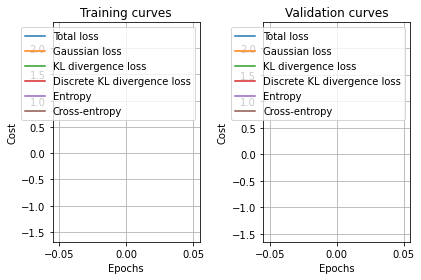

In [13]:
data_size = 784
no_classes = 10
latent_size = 10
CURL_flag = True
Gumbel_flag = False
epochs = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

encode_dict = { "ff_layers":[data_size, 512, 256, 128, latent_size],
                "conv_flag":False }

decode_dict = { "ff_layers":[latent_size, 128, 256, 512, data_size],
                "conv_flag":False }

prior_dict = {  "ff_layers":[no_classes, 512, 256, 128, latent_size],
                 "conv_flag":False }

model = MoG_VAE_model(data_size, 
                      latent_size, 
                      no_classes, 
                      epochs, 
                      encode_dict, 
                      decode_dict, 
                      prior_dict, 
                      binary_decode = True, 
                      var_decode = False, 
                      continuous_prior = False, 
                      CURL_flag = CURL_flag, 
                      Gumbel_flag = Gumbel_flag)

model.to(model.device)

with torch.no_grad():
    labels = torch.arange(0, no_classes)
    U = torch.eye(no_classes).to(device)
    mu_zp, var_zp = model.prior(U)#

    mu_zp = mu_zp.cpu().numpy()
    var_zp = var_zp.cpu().numpy()

    #print(mu_zp, var_zp)

MoG_VAE_opt = MoG_VAE_optimiser(model, Params = None, CURL_flag = CURL_flag)

MoG_VAE_cost = MoG_VAE_loss(no_classes, 
                            "BCE", 
                            gamma = 1, 
                            beta = 2, 
                            alpha = 1,
                            CURL_flag = CURL_flag,
                            Gumbel_flag = Gumbel_flag)

my_trainer = MoG_VAE_trainer(model, 
                             MoG_VAE_opt, 
                             MoG_VAE_cost, 
                             train_loader, 
                             valid_loader,
                            labelled_iterator = ss_loader,#None,#
                             epochs = epochs)

my_trainer.train_model()
my_trainer.plotter()

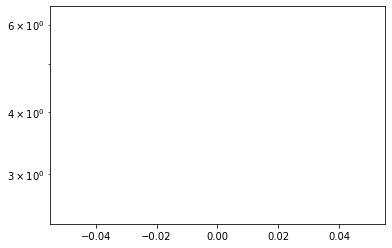

In [14]:
plt.figure()
plt.semilogy(np.array(my_trainer.train_cost)[:, -2])
plt.plot(np.array(my_trainer.train_cost)[:, -1])
plt.show()

# Visualise model responses

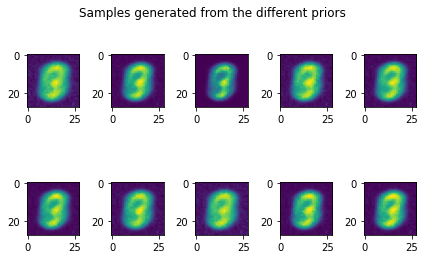

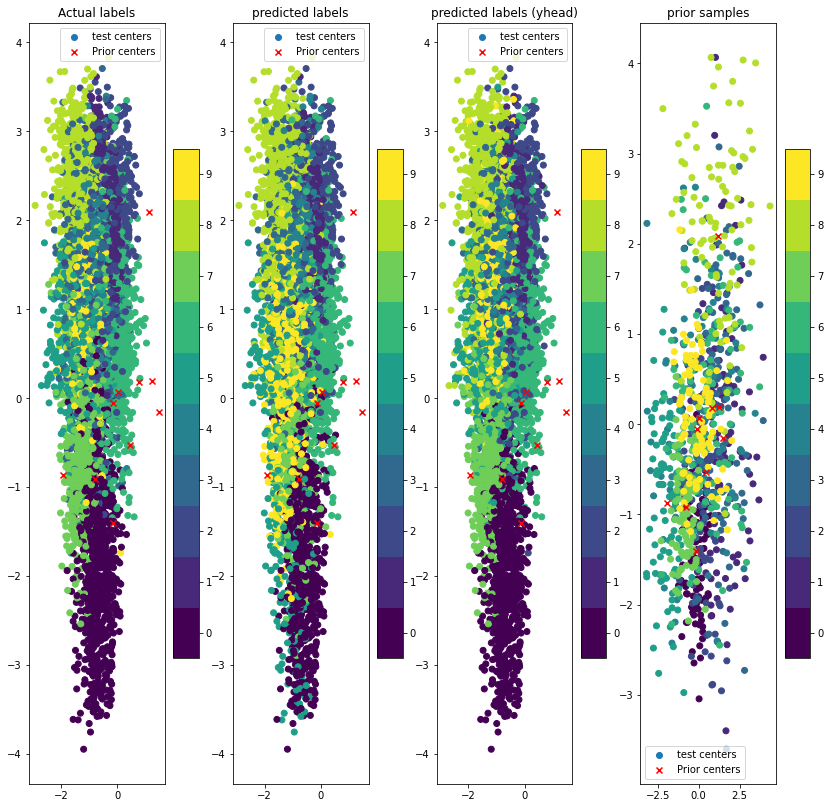


Beginning T-SNE reduction of the conventionally processed data...
T-SNE Done! 120.632s


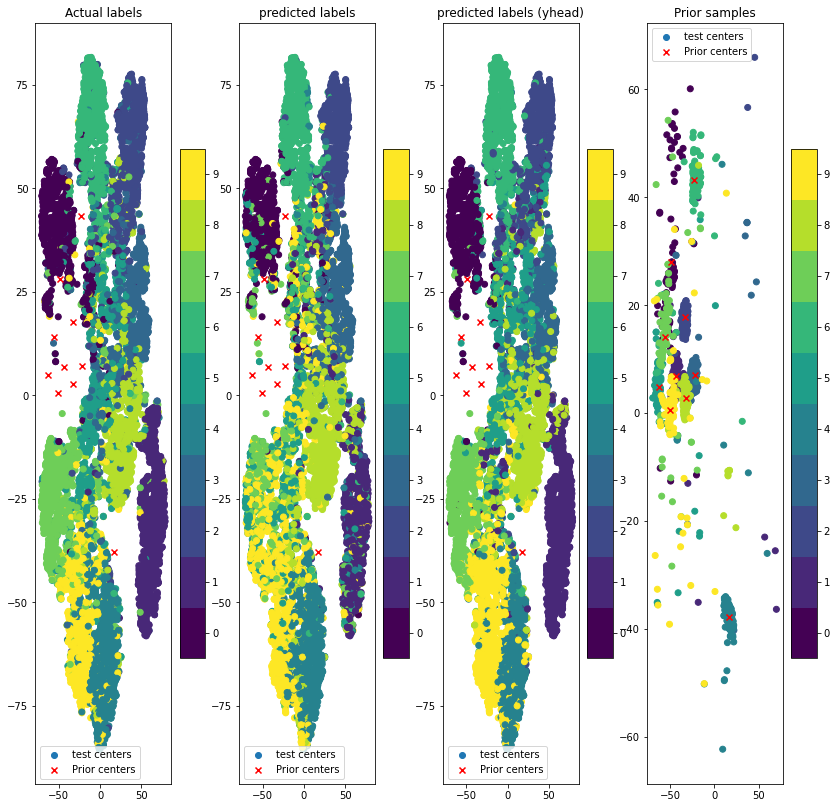

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    labels = torch.arange(0, no_classes)
    U = torch.eye(no_classes).to(device)
    mu_zp, var_zp = model.prior(U)#
    
    x, _, _ = model.decoder(mu_zp, torch.zeros_like(var_zp))
    
    mu_zp = mu_zp.cpu().numpy()
    var_zp = var_zp.cpu().numpy()
    x = x.cpu().numpy()

fig, ax = plt.subplots(2, 5)
ax = ax.flatten()
fig.suptitle("Samples generated from the different priors")
for i in range(10):
    ax[i].imshow(x[i, :].reshape(28, 28))
fig.tight_layout()
plt.show()

q_post = np.array([[]])
q_curl = np.array([[]])
l_list = np.array([[]])

for cnt, i in enumerate(test_loader):
    d, l = i
    d = d.to(device)
    mu_z, _, _, _ = model.encoder(d, expand_flag = False)
    
    mu_z = mu_z.detach().cpu().numpy()
    
    l_post, l_curl = model.infer_label(d)

    l_post = l_post.detach().cpu().numpy()
    
    try:
        l_curl = l_curl.detach().cpu().numpy()
    except:
        l_curl = np.ones_like(l_post) * -999
        
    l_actual = l.numpy()
    
    if cnt == 0:
        mu_z_total = mu_z
        l_post_total = l_post
        l_curl_total = l_curl
        l_actual_total = l_actual
    else:
        mu_z_total = np.vstack((mu_z_total, mu_z))
        l_post_total = np.concatenate((l_post_total, l_post))
        l_curl_total = np.concatenate((l_curl_total, l_curl))
        l_actual_total = np.concatenate((l_actual_total, l_actual.reshape(-1)))

#MAKE SAMPLES FROM THE PRIOR MODEL

sampled_data = np.zeros((1, mu_zp.shape[1]))
sampled_labels = []
for i in range(10):
  sample = mu_zp[i, :] + np.random.randn(100, mu_zp.shape[1]) * np.sqrt(var_zp[i, :])
  sampled_data = np.vstack((sampled_data, sample))
  sampled_labels += [i] * 100

sampled_data = sampled_data[1:, :]
####################################

fig, ax = plt.subplots(1, 4 if model.CURL_flag else 3, figsize = (14, 14))
ax = ax.flatten() 

cmap = plt.get_cmap('viridis', no_classes)
tick_locs = (np.arange(no_classes) + 0.5)*(no_classes-1)/no_classes

index1 = 0
index2 = 1

ax[0].set_title("Actual labels")
c = ax[0].scatter(mu_z_total[:, index1], mu_z_total[:, index2], c = l_actual_total, cmap = cmap, label = "test centers")
ax[0].scatter(mu_zp[:, index1], mu_zp[:, index2], color = "r", marker = "x", label = "Prior centers")
ax[0].legend()

cb = fig.colorbar(c, ax = ax[0])
tick_locs = (np.arange(no_classes) + 0.5)*(no_classes-1)/no_classes
cb.set_ticks(tick_locs)
# set tick labels (as before)
cb.set_ticklabels(np.arange(no_classes))

ax[1].set_title("predicted labels")
c = ax[1].scatter(mu_z_total[:, index1], mu_z_total[:, index2], c = l_post_total, cmap = cmap, label = "test centers")
ax[1].scatter(mu_zp[:, index1], mu_zp[:, index2], color = "r", marker = "x", label = "Prior centers")
ax[1].legend()
cb = fig.colorbar(c, ax = ax[1])
cb.set_ticks(tick_locs)
# set tick labels (as before)
cb.set_ticklabels(np.arange(no_classes))

if CURL_flag:
    ax[2].set_title("predicted labels (yhead)")
    c = ax[2].scatter(mu_z_total[:, index1], mu_z_total[:, index2], c = l_curl_total, cmap = cmap, label = "test centers")
    ax[2].scatter(mu_zp[:, index1], mu_zp[:, index2], color = "r", marker = "x", label = "Prior centers")
    ax[2].legend()
    cb = fig.colorbar(c, ax = ax[2])

    cb.set_ticks(tick_locs)
    # set tick labels (as before)
    cb.set_ticklabels(np.arange(no_classes))

ax[-1].set_title("prior samples")
c = ax[-1].scatter(sampled_data[:, index1], sampled_data[:, index2], c = sampled_labels, cmap = cmap, label = "test centers")
ax[-1].scatter(mu_zp[:, index1], mu_zp[:, index2], color = "r", marker = "x", label = "Prior centers")
ax[-1].legend()
cb = fig.colorbar(c, ax = ax[-1])

cb.set_ticks(tick_locs)
# set tick labels (as before)
cb.set_ticklabels(np.arange(no_classes))
    

fig.tight_layout
plt.show()
#########################################################
#T-SNE for data
#########################################################

data_plot = np.vstack((mu_z_total, mu_zp, sampled_data))

if latent_size > 50:

    print("Performing PCA to reduce time requirements...")
    t0 = time_module.time()
    pca = PCA(n_components = 50)
    Data = pca.fit_transform(data_plot)
    print("PCA Done! {:.3f}s".format(time_module.time() - t0))

else:
    Data = data_plot
  
print("\nBeginning T-SNE reduction of the conventionally processed data...")
t0 = time_module.time()
tsne = TSNE(n_components = 2)
T_2D = tsne.fit_transform(Data)
print("T-SNE Done! {:.3f}s".format(time_module.time() - t0))

T_2D_total = T_2D[:mu_z_total.shape[0], :]
T_2D_zp = T_2D[mu_z_total.shape[0]:-1000, :]
T_2D_prior = T_2D[-1000:, :]

fig, ax = plt.subplots(1, 4 if model.CURL_flag else 3, figsize = (14, 14))

ax = ax.flatten() 

ax[0].set_title("Actual labels")
c = ax[0].scatter(T_2D_total[:, 0], T_2D_total[:, 1], c = l_actual_total, cmap = cmap, label = "test centers")
ax[0].scatter(T_2D_zp[:, 0], T_2D_zp[:, 1], color = "r", marker = "x", label = "Prior centers")
ax[0].legend()
cb = fig.colorbar(c, ax = ax[0])
cb.set_ticks(tick_locs)
# set tick labels (as before)
cb.set_ticklabels(np.arange(no_classes))

ax[1].set_title("predicted labels")
c = ax[1].scatter(T_2D_total[:, 0], T_2D_total[:, 1], c = l_post_total, cmap = cmap, label = "test centers")
ax[1].scatter(T_2D_zp[:, 0], T_2D_zp[:, 1], color = "r", marker = "x", label = "Prior centers")
ax[1].legend()
cb = fig.colorbar(c, ax = ax[1])
cb.set_ticks(tick_locs)
# set tick labels (as before)
cb.set_ticklabels(np.arange(no_classes))

if CURL_flag:
    ax[2].set_title("predicted labels (yhead)")
    c = ax[2].scatter(T_2D_total[:, 0], T_2D_total[:, 1], c = l_curl_total, cmap = cmap, label = "test centers")
    ax[2].scatter(T_2D_zp[:, 0], T_2D_zp[:, 1], color = "r", marker = "x", label = "Prior centers")
    ax[2].legend()
    cb = fig.colorbar(c, ax = ax[2])
    cb.set_ticks(tick_locs)
    # set tick labels (as before)
    cb.set_ticklabels(np.arange(no_classes))

ax[-1].set_title("Prior samples")
c = ax[-1].scatter(T_2D_prior[:, 0], T_2D_prior[:, 1], c = sampled_labels, cmap = cmap, label = "test centers")
ax[-1].scatter(T_2D_zp[:, 0], T_2D_zp[:, 1], color = "r", marker = "x", label = "Prior centers")
ax[-1].legend()
cb = fig.colorbar(c, ax = ax[-1])
cb.set_ticks(tick_locs)
# set tick labels (as before)
cb.set_ticklabels(np.arange(no_classes))

fig.tight_layout
plt.show()

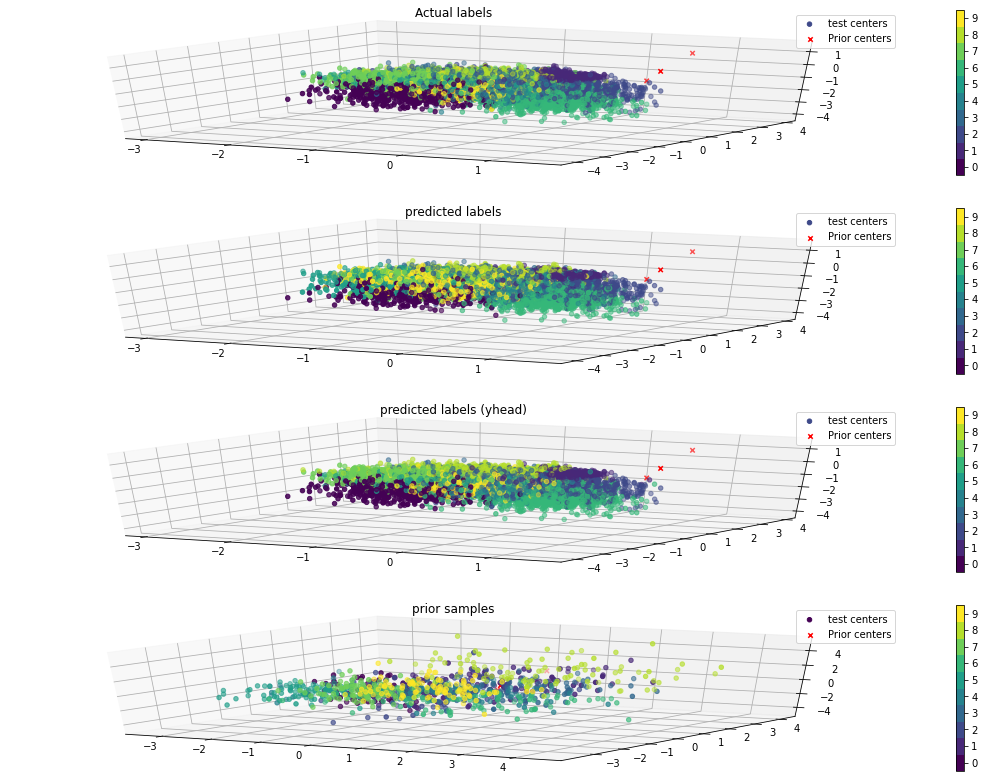

In [16]:


fig = plt.figure(figsize = (20, 14))
num = 410 if CURL_flag else 310
ax1 = fig.add_subplot(num + 1, projection = "3d")
ax2 = fig.add_subplot(num + 2, projection = "3d")
ax3 = fig.add_subplot(num + 3, projection = "3d")

if CURL_flag:
    ax4 = [fig.add_subplot(num + 4, projection = "3d")]
else:
    ax4 = []

ax = [ax1, ax2, ax3] + ax4

cmap = plt.get_cmap('viridis', no_classes)
tick_locs = (np.arange(no_classes) + 0.5)*(no_classes-1)/no_classes

index1 = 0
index2 = 1
index3 = 2

ax[0].set_title("Actual labels")
c = ax[0].scatter(mu_z_total[:, index1], mu_z_total[:, index2], mu_z_total[:, index3], c = l_actual_total, cmap = cmap, label = "test centers")
ax[0].scatter(mu_zp[:, index1], mu_zp[:, index2], mu_zp[:, index3], color = "r", marker = "x", label = "Prior centers")
ax[0].legend()
cb = fig.colorbar(c, ax = ax[0])
tick_locs = (np.arange(no_classes) + 0.5)*(no_classes-1)/no_classes
cb.set_ticks(tick_locs)
# set tick labels (as before)
cb.set_ticklabels(np.arange(no_classes))

ax[1].set_title("predicted labels")
c = ax[1].scatter(mu_z_total[:, index1], mu_z_total[:, index2], mu_z_total[:, index3], c = l_post_total, cmap = cmap, label = "test centers")
ax[1].scatter(mu_zp[:, index1], mu_zp[:, index2], mu_zp[:, index3], color = "r", marker = "x", label = "Prior centers")
ax[1].legend()
cb = fig.colorbar(c, ax = ax[1])
cb.set_ticks(tick_locs)
# set tick labels (as before)
cb.set_ticklabels(np.arange(no_classes))

if CURL_flag:
    ax[2].set_title("predicted labels (yhead)")
    c = ax[2].scatter(mu_z_total[:, index1], mu_z_total[:, index2], mu_z_total[:, index3], c = l_curl_total, cmap = cmap, label = "test centers")
    ax[2].scatter(mu_zp[:, index1], mu_zp[:, index2], mu_zp[:, index3], color = "r", marker = "x", label = "Prior centers")
    ax[2].legend()
    cb = fig.colorbar(c, ax = ax[2])

    cb.set_ticks(tick_locs)
    # set tick labels (as before)
    cb.set_ticklabels(np.arange(no_classes))

ax[-1].set_title("prior samples")
c = ax[-1].scatter(sampled_data[:, index1], sampled_data[:, index2], sampled_data[:, index3], c = sampled_labels, cmap = cmap, label = "test centers")
ax[-1].scatter(mu_zp[:, index1], mu_zp[:, index2], mu_zp[:, index3], color = "r", marker = "x", label = "Prior centers")
ax[-1].legend()
cb = fig.colorbar(c, ax = ax[-1])

cb.set_ticks(tick_locs)
# set tick labels (as before)
cb.set_ticklabels(np.arange(no_classes))

fig.tight_layout
plt.show()


Beginning T-SNE reduction of the conventionally processed data...
T-SNE Done! 661.292s


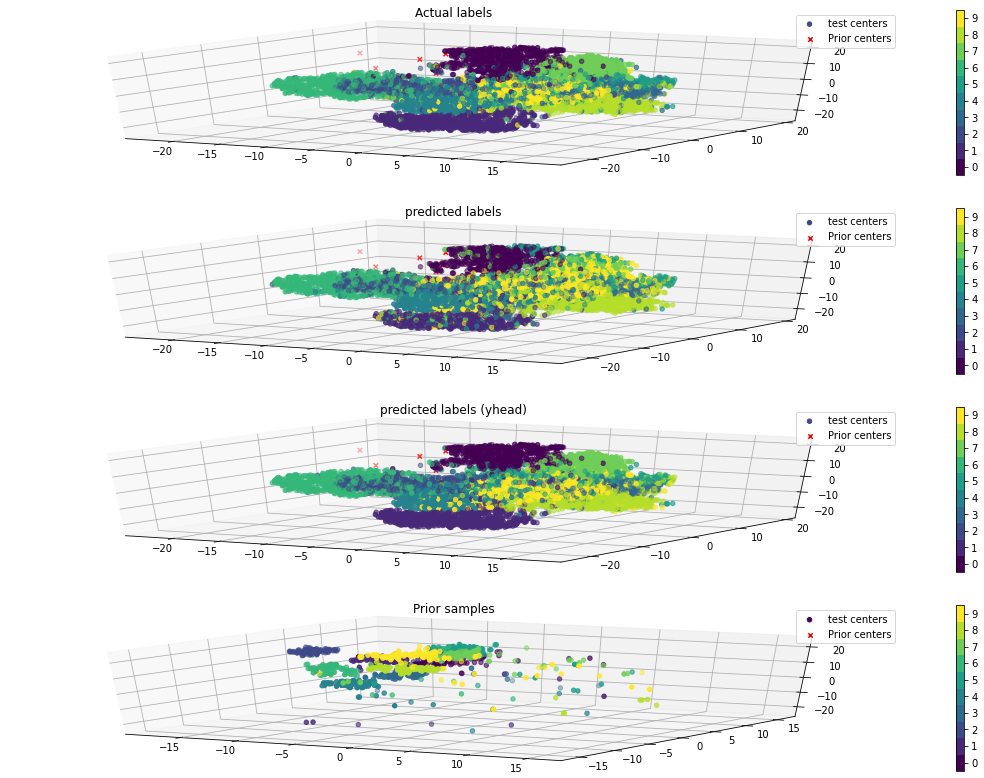

In [17]:
#########################################################
#T-SNE for data
#########################################################

data_plot = np.vstack((mu_z_total, mu_zp, sampled_data))

if latent_size > 50:

    print("Performing PCA to reduce time requirements...")
    t0 = time_module.time()
    pca = PCA(n_components = 50)
    Data = pca.fit_transform(data_plot)
    print("PCA Done! {:.3f}s".format(time_module.time() - t0))

else:
    Data = data_plot
  
print("\nBeginning T-SNE reduction of the conventionally processed data...")
t0 = time_module.time()
tsne = TSNE(n_components = 3)
T_2D = tsne.fit_transform(Data)
print("T-SNE Done! {:.3f}s".format(time_module.time() - t0))

T_2D_total = T_2D[:mu_z_total.shape[0], :]
T_2D_zp = T_2D[mu_z_total.shape[0]:-1000, :]
T_2D_prior = T_2D[-1000:, :]

fig = plt.figure(figsize = (20, 14))
num = 410 if CURL_flag else 310
ax1 = fig.add_subplot(num + 1, projection = "3d")
ax2 = fig.add_subplot(num + 2, projection = "3d")
ax3 = fig.add_subplot(num + 3, projection = "3d")

if CURL_flag:
    ax4 = [fig.add_subplot(num + 4, projection = "3d")]
else:
    ax4 = []

ax = [ax1, ax2, ax3] + ax4

ax[0].set_title("Actual labels")
c = ax[0].scatter(T_2D_total[:, 0], T_2D_total[:, 1], T_2D_total[:, 2], c = l_actual_total, cmap = cmap, label = "test centers")
ax[0].scatter(T_2D_zp[:, 0], T_2D_zp[:, 1], T_2D_zp[:, 2], color = "r", marker = "x", label = "Prior centers")
ax[0].legend()
cb = fig.colorbar(c, ax = ax[0])
cb.set_ticks(tick_locs)
# set tick labels (as before)
cb.set_ticklabels(np.arange(no_classes))

ax[1].set_title("predicted labels")
c = ax[1].scatter(T_2D_total[:, 0], T_2D_total[:, 1], T_2D_total[:, 2], c = l_post_total, cmap = cmap, label = "test centers")
ax[1].scatter(T_2D_zp[:, 0], T_2D_zp[:, 1], T_2D_zp[:, 2], color = "r", marker = "x", label = "Prior centers")
ax[1].legend()
cb = fig.colorbar(c, ax = ax[1])
cb.set_ticks(tick_locs)
# set tick labels (as before)
cb.set_ticklabels(np.arange(no_classes))

if CURL_flag:
    ax[2].set_title("predicted labels (yhead)")
    c = ax[2].scatter(T_2D_total[:, 0], T_2D_total[:, 1], T_2D_total[:, 2], c = l_curl_total, cmap = cmap, label = "test centers")
    ax[2].scatter(T_2D_zp[:, 0], T_2D_zp[:, 1], T_2D_zp[:, 2], color = "r", marker = "x", label = "Prior centers")
    ax[2].legend()
    cb = fig.colorbar(c, ax = ax[2])
    cb.set_ticks(tick_locs)
    # set tick labels (as before)
    cb.set_ticklabels(np.arange(no_classes))

ax[-1].set_title("Prior samples")
c = ax[-1].scatter(T_2D_prior[:, 0], T_2D_prior[:, 1], T_2D_prior[:, 2], c = sampled_labels, cmap = cmap, label = "test centers")
ax[-1].scatter(T_2D_zp[:, 0], T_2D_zp[:, 1], T_2D_zp[:, 2], color = "r", marker = "x", label = "Prior centers")
ax[-1].legend()
cb = fig.colorbar(c, ax = ax[-1])
cb.set_ticks(tick_locs)
# set tick labels (as before)
cb.set_ticklabels(np.arange(no_classes))

fig.tight_layout
plt.show()

In [18]:
np.save("test_3D.npy", {"T_3D_total":mu_z_total,
                     "T_3D_zp":mu_zp,
                     "labels":l_actual_total})

In [19]:
print(l_post_total[:100])
print(l_curl_total[:100])
print(l_actual_total[:100])


[2 0 4 1 1 2 4 6 6 3 8 9 5 7 4 4 9 3 0 6 4 4 6 6 5 1 8 9 8 3 6 5 4 8 9 6 9
 1 9 3 4 6 8 6 5 6 5 0 1 7 6 9 0 7 8 5 3 1 6 1 4 3 8 0 0 1 4 8 9 7 9 6 7 8
 6 3 1 8 2 9 4 0 8 8 8 3 4 2 5 9 6 7 3 5 1 9 1 6 7 9]
[2 0 9 6 2 2 4 6 6 3 9 1 9 1 4 3 9 3 0 8 6 4 6 6 8 8 8 9 8 3 6 5 1 5 2 6 9
 1 9 3 1 2 8 6 0 1 1 0 1 5 6 7 5 0 5 8 5 1 5 1 4 5 8 0 0 1 1 3 2 1 2 6 5 8
 6 3 8 8 2 9 9 5 8 8 8 3 6 2 7 9 2 7 8 0 1 7 1 6 7 4]
[2 0 9 3 2 2 4 5 6 8 0 1 9 1 4 3 9 3 0 6 6 4 6 6 5 0 8 7 8 3 6 5 1 8 9 6 7
 1 9 3 1 2 8 6 0 1 1 0 1 5 6 7 5 0 8 8 3 1 5 1 4 3 8 0 0 1 1 3 2 1 3 6 5 8
 6 3 1 7 2 9 9 5 8 1 8 3 4 2 7 9 2 7 3 0 1 7 1 6 7 4]


In [20]:

for scale in [1, 10, 100, 1000, 10000]:
    a = torch.rand(10, 10, requires_grad = False)
    a[:, 0] = scale
    for i in range(a.size(0)):
        a[i, :] /= torch.sum(torch.sqrt(a[i, :]**2))

    a = a.requires_grad_(True)
    #print(a)

    l = discrete_KL_divergence(10)
    a = torch.repeat_interleave(a, 10, dim =0)
    loss = l(a, torch.ones(1,10)/10)
    print(torch.mean(loss[0]).item(), loss[1].item(), loss[2].item())

#a = a / torch.sum(a)

#print(a)
#print(-1 * torch.sum(a * torch.log(a)))

-226.54034423828125 2.1187031269073486 2.3025851249694824
-129.4293212890625 1.2180676460266113 2.3025853633880615
-27.84856414794922 0.24869422614574432 2.3025853633880615
-6.279187202453613 0.03927871212363243 2.3025853633880615
-2.8133373260498047 0.0050628227181732655 2.3025851249694824
